In [1]:
#Import tensorflow

import tensorflow as tf
tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
#Test if GPU is found

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

GPU found


In [3]:
# Autosaving every 10s

%autosave 10

Autosaving every 10 seconds


In [4]:
#Training & Testing files

train_file = "train9.csv"
val_file = "val9.csv"
matlab_file = '1_50_9.mat'
rul_file = "rul_50_9.csv"
fleet_Rul_File = "rul9.csv"
test_file = "test9.csv"

In [5]:
import pandas as pd
import numpy as np
import scipy.io
import tensorflow_probability as tfp
import matplotlib as plt
import matplotlib.pyplot as plt
import pickle
import scipy.io as spio
import pickle
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.models import Sequential, model_from_json, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Masking
tfd = tfp.distributions

In [6]:
# fix random seed for reproducibility

np.random.seed(0)

In [7]:
# load Training & Testing Files into Pandas Dataframes

train = pd.read_csv(train_file, index_col=False)
val = pd.read_csv(val_file, index_col=False)
mat = spio.loadmat(matlab_file, squeeze_me=True)

C:\Users\Asus\anaconda3\lib\site-packages\scipy\io\matlab\mio.py:218: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [8]:
#Load Hyperparameters obtained by BayesOpt

lr = mat['lr']
ep = mat['ep']
batch = mat['batch']
pad = mat['Pad']
L2 = mat['L2'] 
unit1 = mat['unit'] 
size1 = mat['size']
drop1 = mat['drop']

lr,ep,batch,pad,L2,unit1,size1,drop1

(0.0005063884626535699, 1e-08, 70, 303, 0.0001, 51, 171, 0.4902145707827831)

In [9]:
#Xtrain to Numpy multidimensional array

xtrain_cut = train.drop(['Fleet','Cycle','RUL'], axis=1)
xtrain = np.zeros((train['Fleet'].max(),pad,xtrain_cut.shape[1]))
for i in range(train['Fleet'].max()):
    df_xtrain = train.loc[train['Fleet']==i+1]
    df_xtrain = df_xtrain.drop(['Fleet','Cycle','RUL'], axis=1)
    np_xtrain = df_xtrain.values
    result = np.zeros((pad,df_xtrain.shape[1]))
    result[:np_xtrain.shape[0],:np_xtrain.shape[1]] = np_xtrain
    xtrain[i] = result
xtrain.shape

(100, 303, 9)

In [10]:
#Ytrain to Numpy multidimensional array

ytrain_cut = train[['RUL']]
ytrain = np.zeros((train['Fleet'].max(),pad,1))
for i in range(train['Fleet'].max()):
    df_ytrain = train.loc[train['Fleet']==i+1]
    df_ytrain = df_ytrain[['RUL']]
    np_ytrain = df_ytrain.values
    result = np.zeros((pad,df_ytrain.shape[1]))
    result[:np_ytrain.shape[0],:np_ytrain.shape[1]] = np_ytrain
    ytrain[i] = result
ytrain.shape

(100, 303, 1)

In [11]:
#Ytrain2 to Numpy multidimensional array - for SHAP

ytrain2 = np.zeros(train['Fleet'].max())
for i in range(train['Fleet'].max()):
    df_ytrain2 = train.loc[train['Fleet']==i+1]
    df_ytrain2 = df_ytrain2[['RUL']].values
    ytrain2[i] = df_ytrain2[0]
ytrain2.shape

(100,)

In [12]:
#Xval to Numpy multidimensional array

xval_cut = val.drop(['RUL','Fleet','Cycle'], axis=1)
xval = np.zeros((val['Fleet'].max(),pad,xval_cut.shape[1]))
for i in range(val['Fleet'].max()):
    df_xval = val.loc[val['Fleet']==i+1]
    df_xval = df_xval.drop(['Fleet','Cycle','RUL'], axis=1)
    np_xval = df_xval.values
    result = np.zeros((pad,df_xval.shape[1]))
    result[:np_xval.shape[0],:np_xval.shape[1]] = np_xval
    xval[i] = result
xval.shape

(100, 303, 9)

In [13]:
#Yval to Numpy multidimensional array - for sequential prediction 

yval_cut = val[['RUL']]
yval = np.zeros((val['Fleet'].max(),pad,1))
for i in range(val['Fleet'].max()):
    df_yval = val.loc[val['Fleet']==i+1]
    df_yval = df_yval[['RUL']]
    np_yval = df_yval.values
    result = np.zeros((pad,df_yval.shape[1]))
    result[:np_yval.shape[0],:np_yval.shape[1]] = np_yval
    yval[i] = result
yval.shape

(100, 303, 1)

In [14]:
#Yval2 to Numpy multidimensional array - for SHAP 

yval2 = np.zeros(train['Fleet'].max())
for i in range(train['Fleet'].max()):
    df_yval2 = train.loc[train['Fleet']==i+1]
    df_yval2 = df_yval2[['RUL']].values
    yval2[i] = df_yval2[0]
yval2.shape

(100,)

In [15]:
#xtest to Numpy multidimensional array 

test = pd.read_csv(test_file, index_col=False)
xtest_cut = test.drop(['Fleet','Cycle'], axis=1)
xtest = np.zeros((test['Fleet'].max(),pad,xtest_cut.shape[1]))
for i in range(test['Fleet'].max()):
    df_xtest = test.loc[test['Fleet']==i+1]
    df_xtest = df_xtest.drop(['Fleet','Cycle'], axis=1)
    np_xtest = df_xtest.values
    result = np.zeros((pad,df_xtest.shape[1]))
    result[:np_xtest.shape[0],:np_xtest.shape[1]] = np_xtest
    xtest[i] = result

In [16]:
#Verify Shapes of Array

xtrain.shape,ytrain.shape, ytrain2.shape,xval.shape,yval.shape,yval2.shape,xtest.shape

((100, 303, 9),
 (100, 303, 1),
 (100,),
 (100, 303, 9),
 (100, 303, 1),
 (100,),
 (100, 303, 9))

In [17]:
xtrain = xtrain.astype(np.float32)
ytrain = ytrain.astype(np.float32)
ytrain2 = ytrain2.astype(np.float32)
xval = xval.astype(np.float32)
yval = yval.astype(np.float32)
yval2 = yval2.astype(np.float32)
xtest = xtest.astype(np.float32)

In [18]:
#Set ytrain for 3 outputs

x_train = xtrain
y_train = [ytrain,ytrain,ytrain2]
x_val = xval
y_val = [yval,yval,yval2]
x_test = xtest

In [19]:
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback,ReduceLROnPlateau
from tensorflow.keras.layers import Flatten, Reshape
import warnings
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Lambda, concatenate
from tensorflow.keras.models import Model
from IPython.display import display

In [20]:
# Define trainable prior

def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.))
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])

# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
  ])

In [28]:
#Define probabilistic LSTM

# LSTM Layers (layer 1,2&3)

inputs = tf.keras.Input(shape=(303,9),dtype='float32')
layer1 = LSTM(unit1,return_sequences = True)(inputs)
layer2 = Dense(size1)(layer1)

#Output 1 = Aleatoric output layer (layer 3&4)

layer3 = Dense(1+1)(layer2)
layer4 = tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[..., :1],scale=1e-3 + tf.math.softplus(0.05 * t[..., 1:])),name='out1')(layer3) #aleatoric

#Output 2 = Epistemic output layer (layer 5&6)

layer5 = tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable)(layer2)
layer6 = tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1),name = 'out2')(layer5)

#Output 3 = Slicer output layer (layer 7&8)

layer7 = Dense(1)(layer2)
layer8 = Lambda(lambda t: t[:,-1],name='out3')(layer7)

model = tf.keras.Model(inputs=inputs, outputs=[layer4,layer6,layer8])
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 303, 9)]     0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 303, 51)      12444       input_2[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 303, 171)     8892        lstm_1[0][0]                     
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 303, 2)       344         dense_3[0][0]                    
_______________________________________________________________________________________

In [29]:
#Define directory for best weights checkpoint

import os
checkpoint_path = "C:/Users/Asus/OneDrive - Universiti Teknologi PETRONAS/Gas Turbine & Turbofan AD & PROGNOS/Turbofan/Turbofan-1 LSTM 9/model checkpoint/1_50_9_ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

#Callback for best weights checkpoint

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose = 1)

In [30]:
#Compile Model

optimizers.Adam(learning_rate=lr, beta_1 = 0.9,beta_2 = 0.999, epsilon = ep, amsgrad = False, name = "Adam")
negloglik = lambda y, rv_y: -rv_y.log_prob(y)
model.compile(loss = {'out1': negloglik,'out2': negloglik,'out3':'mean_squared_error'},loss_weights=[0.5,0.5,0],optimizer= 'Adam')

In [24]:
# Define Tensorboard  

%load_ext tensorboard
import tensorboard
tensorboard.__version__
from datetime import datetime
from tensorflow import keras
# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [25]:
# Run training

history = model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 10000, batch_size  = batch, verbose = 0, callbacks=[model_checkpoint_callback,tensorboard_callback])

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.

Epoch 00001: val_loss improved from inf to 221.83383, saving model to C:/Users/Asus/OneDrive - Universiti Teknologi PETRONAS/New folder/P2/model checkpoint\1_50_9_2_ckpt

Epoch 00002: val_loss improved from 221.83383 to 217.58623, saving model to C:/Users/Asus/OneDrive - Universiti Teknologi PETRONAS/New folder/P2/model checkpoint\1_50_9_2_ckpt

Epoch 00003: val_loss did not improve from 217.58623

Epoch 00004: val_loss improved from 217.58623 to 216.93945, saving model to C:/Users/Asus/OneDrive - Universiti Teknologi PETRONAS/New folder/P2/model checkpoint\1_50_9_2_ckpt

Epoch 00005: val_loss did not improve from 216.93945

Epoch 00006: val_loss improved from 216.93945 to 209.03998, saving model to C:/Users/Asus/OneDrive - Universiti Teknologi PETRONAS/New folder/P2/model checkpoint\1_50_9_2_ckpt

Epoch 00007: val_loss did not improve from 209.03998

Epoch 00008: val_l


Epoch 00097: val_loss did not improve from 107.52177

Epoch 00098: val_loss did not improve from 107.52177

Epoch 00099: val_loss did not improve from 107.52177

Epoch 00100: val_loss did not improve from 107.52177

Epoch 00101: val_loss did not improve from 107.52177

Epoch 00102: val_loss did not improve from 107.52177

Epoch 00103: val_loss did not improve from 107.52177

Epoch 00104: val_loss did not improve from 107.52177

Epoch 00105: val_loss did not improve from 107.52177

Epoch 00106: val_loss did not improve from 107.52177

Epoch 00107: val_loss did not improve from 107.52177

Epoch 00108: val_loss improved from 107.52177 to 104.21209, saving model to C:/Users/Asus/OneDrive - Universiti Teknologi PETRONAS/New folder/P2/model checkpoint\1_50_9_2_ckpt

Epoch 00109: val_loss did not improve from 104.21209

Epoch 00110: val_loss did not improve from 104.21209

Epoch 00111: val_loss did not improve from 104.21209

Epoch 00112: val_loss did not improve from 104.21209

Epoch 00113:


Epoch 00218: val_loss did not improve from 28.87479

Epoch 00219: val_loss did not improve from 28.87479

Epoch 00220: val_loss did not improve from 28.87479

Epoch 00221: val_loss did not improve from 28.87479

Epoch 00222: val_loss did not improve from 28.87479

Epoch 00223: val_loss did not improve from 28.87479

Epoch 00224: val_loss did not improve from 28.87479

Epoch 00225: val_loss did not improve from 28.87479

Epoch 00226: val_loss improved from 28.87479 to 26.52711, saving model to C:/Users/Asus/OneDrive - Universiti Teknologi PETRONAS/New folder/P2/model checkpoint\1_50_9_2_ckpt

Epoch 00227: val_loss did not improve from 26.52711

Epoch 00228: val_loss improved from 26.52711 to 23.71162, saving model to C:/Users/Asus/OneDrive - Universiti Teknologi PETRONAS/New folder/P2/model checkpoint\1_50_9_2_ckpt

Epoch 00229: val_loss did not improve from 23.71162

Epoch 00230: val_loss did not improve from 23.71162

Epoch 00231: val_loss did not improve from 23.71162

Epoch 00232: 


Epoch 00355: val_loss did not improve from 14.27199

Epoch 00356: val_loss did not improve from 14.27199

Epoch 00357: val_loss did not improve from 14.27199

Epoch 00358: val_loss did not improve from 14.27199

Epoch 00359: val_loss did not improve from 14.27199

Epoch 00360: val_loss did not improve from 14.27199

Epoch 00361: val_loss did not improve from 14.27199

Epoch 00362: val_loss did not improve from 14.27199

Epoch 00363: val_loss did not improve from 14.27199

Epoch 00364: val_loss did not improve from 14.27199

Epoch 00365: val_loss did not improve from 14.27199

Epoch 00366: val_loss did not improve from 14.27199

Epoch 00367: val_loss did not improve from 14.27199

Epoch 00368: val_loss did not improve from 14.27199

Epoch 00369: val_loss did not improve from 14.27199

Epoch 00370: val_loss did not improve from 14.27199

Epoch 00371: val_loss did not improve from 14.27199

Epoch 00372: val_loss did not improve from 14.27199

Epoch 00373: val_loss did not improve from 14


Epoch 00501: val_loss improved from 12.22653 to 11.42817, saving model to C:/Users/Asus/OneDrive - Universiti Teknologi PETRONAS/New folder/P2/model checkpoint\1_50_9_2_ckpt

Epoch 00502: val_loss did not improve from 11.42817

Epoch 00503: val_loss did not improve from 11.42817

Epoch 00504: val_loss did not improve from 11.42817

Epoch 00505: val_loss did not improve from 11.42817

Epoch 00506: val_loss did not improve from 11.42817

Epoch 00507: val_loss did not improve from 11.42817

Epoch 00508: val_loss did not improve from 11.42817

Epoch 00509: val_loss did not improve from 11.42817

Epoch 00510: val_loss did not improve from 11.42817

Epoch 00511: val_loss did not improve from 11.42817

Epoch 00512: val_loss did not improve from 11.42817

Epoch 00513: val_loss did not improve from 11.42817

Epoch 00514: val_loss did not improve from 11.42817

Epoch 00515: val_loss did not improve from 11.42817

Epoch 00516: val_loss did not improve from 11.42817

Epoch 00517: val_loss did not


Epoch 00645: val_loss did not improve from 8.38381

Epoch 00646: val_loss did not improve from 8.38381

Epoch 00647: val_loss did not improve from 8.38381

Epoch 00648: val_loss did not improve from 8.38381

Epoch 00649: val_loss did not improve from 8.38381

Epoch 00650: val_loss did not improve from 8.38381

Epoch 00651: val_loss did not improve from 8.38381

Epoch 00652: val_loss did not improve from 8.38381

Epoch 00653: val_loss did not improve from 8.38381

Epoch 00654: val_loss did not improve from 8.38381

Epoch 00655: val_loss did not improve from 8.38381

Epoch 00656: val_loss did not improve from 8.38381

Epoch 00657: val_loss did not improve from 8.38381

Epoch 00658: val_loss did not improve from 8.38381

Epoch 00659: val_loss did not improve from 8.38381

Epoch 00660: val_loss did not improve from 8.38381

Epoch 00661: val_loss did not improve from 8.38381

Epoch 00662: val_loss did not improve from 8.38381

Epoch 00663: val_loss did not improve from 8.38381

Epoch 00664


Epoch 00803: val_loss did not improve from 8.38381

Epoch 00804: val_loss did not improve from 8.38381

Epoch 00805: val_loss did not improve from 8.38381

Epoch 00806: val_loss did not improve from 8.38381

Epoch 00807: val_loss did not improve from 8.38381

Epoch 00808: val_loss did not improve from 8.38381

Epoch 00809: val_loss did not improve from 8.38381

Epoch 00810: val_loss did not improve from 8.38381

Epoch 00811: val_loss did not improve from 8.38381

Epoch 00812: val_loss did not improve from 8.38381

Epoch 00813: val_loss did not improve from 8.38381

Epoch 00814: val_loss did not improve from 8.38381

Epoch 00815: val_loss did not improve from 8.38381

Epoch 00816: val_loss did not improve from 8.38381

Epoch 00817: val_loss did not improve from 8.38381

Epoch 00818: val_loss did not improve from 8.38381

Epoch 00819: val_loss did not improve from 8.38381

Epoch 00820: val_loss did not improve from 8.38381

Epoch 00821: val_loss did not improve from 8.38381

Epoch 00822


Epoch 01109: val_loss did not improve from 7.40424

Epoch 01110: val_loss did not improve from 7.40424

Epoch 01111: val_loss did not improve from 7.40424

Epoch 01112: val_loss did not improve from 7.40424

Epoch 01113: val_loss did not improve from 7.40424

Epoch 01114: val_loss did not improve from 7.40424

Epoch 01115: val_loss did not improve from 7.40424

Epoch 01116: val_loss did not improve from 7.40424

Epoch 01117: val_loss did not improve from 7.40424

Epoch 01118: val_loss did not improve from 7.40424

Epoch 01119: val_loss did not improve from 7.40424

Epoch 01120: val_loss did not improve from 7.40424

Epoch 01121: val_loss did not improve from 7.40424

Epoch 01122: val_loss did not improve from 7.40424

Epoch 01123: val_loss did not improve from 7.40424

Epoch 01124: val_loss did not improve from 7.40424

Epoch 01125: val_loss did not improve from 7.40424

Epoch 01126: val_loss did not improve from 7.40424

Epoch 01127: val_loss did not improve from 7.40424

Epoch 01128


Epoch 01260: val_loss did not improve from 6.54446

Epoch 01261: val_loss did not improve from 6.54446

Epoch 01262: val_loss did not improve from 6.54446

Epoch 01263: val_loss did not improve from 6.54446

Epoch 01264: val_loss did not improve from 6.54446

Epoch 01265: val_loss did not improve from 6.54446

Epoch 01266: val_loss did not improve from 6.54446

Epoch 01267: val_loss did not improve from 6.54446

Epoch 01268: val_loss did not improve from 6.54446

Epoch 01269: val_loss did not improve from 6.54446

Epoch 01270: val_loss did not improve from 6.54446

Epoch 01271: val_loss did not improve from 6.54446

Epoch 01272: val_loss did not improve from 6.54446

Epoch 01273: val_loss did not improve from 6.54446

Epoch 01274: val_loss did not improve from 6.54446

Epoch 01275: val_loss did not improve from 6.54446

Epoch 01276: val_loss did not improve from 6.54446

Epoch 01277: val_loss did not improve from 6.54446

Epoch 01278: val_loss did not improve from 6.54446

Epoch 01279


Epoch 01411: val_loss did not improve from 5.88300

Epoch 01412: val_loss did not improve from 5.88300

Epoch 01413: val_loss did not improve from 5.88300

Epoch 01414: val_loss did not improve from 5.88300

Epoch 01415: val_loss did not improve from 5.88300

Epoch 01416: val_loss did not improve from 5.88300

Epoch 01417: val_loss did not improve from 5.88300

Epoch 01418: val_loss did not improve from 5.88300

Epoch 01419: val_loss did not improve from 5.88300

Epoch 01420: val_loss did not improve from 5.88300

Epoch 01421: val_loss did not improve from 5.88300

Epoch 01422: val_loss did not improve from 5.88300

Epoch 01423: val_loss did not improve from 5.88300

Epoch 01424: val_loss did not improve from 5.88300

Epoch 01425: val_loss did not improve from 5.88300

Epoch 01426: val_loss did not improve from 5.88300

Epoch 01427: val_loss did not improve from 5.88300

Epoch 01428: val_loss did not improve from 5.88300

Epoch 01429: val_loss did not improve from 5.88300

Epoch 01430


Epoch 01568: val_loss did not improve from 4.77813

Epoch 01569: val_loss did not improve from 4.77813

Epoch 01570: val_loss did not improve from 4.77813

Epoch 01571: val_loss did not improve from 4.77813

Epoch 01572: val_loss did not improve from 4.77813

Epoch 01573: val_loss did not improve from 4.77813

Epoch 01574: val_loss did not improve from 4.77813

Epoch 01575: val_loss did not improve from 4.77813

Epoch 01576: val_loss did not improve from 4.77813

Epoch 01577: val_loss did not improve from 4.77813

Epoch 01578: val_loss did not improve from 4.77813

Epoch 01579: val_loss did not improve from 4.77813

Epoch 01580: val_loss did not improve from 4.77813

Epoch 01581: val_loss did not improve from 4.77813

Epoch 01582: val_loss did not improve from 4.77813

Epoch 01583: val_loss did not improve from 4.77813

Epoch 01584: val_loss did not improve from 4.77813

Epoch 01585: val_loss did not improve from 4.77813

Epoch 01586: val_loss did not improve from 4.77813

Epoch 01587


Epoch 01725: val_loss did not improve from 4.62811

Epoch 01726: val_loss did not improve from 4.62811

Epoch 01727: val_loss did not improve from 4.62811

Epoch 01728: val_loss did not improve from 4.62811

Epoch 01729: val_loss did not improve from 4.62811

Epoch 01730: val_loss did not improve from 4.62811

Epoch 01731: val_loss did not improve from 4.62811

Epoch 01732: val_loss did not improve from 4.62811

Epoch 01733: val_loss did not improve from 4.62811

Epoch 01734: val_loss did not improve from 4.62811

Epoch 01735: val_loss did not improve from 4.62811

Epoch 01736: val_loss did not improve from 4.62811

Epoch 01737: val_loss did not improve from 4.62811

Epoch 01738: val_loss did not improve from 4.62811

Epoch 01739: val_loss did not improve from 4.62811

Epoch 01740: val_loss did not improve from 4.62811

Epoch 01741: val_loss did not improve from 4.62811

Epoch 01742: val_loss did not improve from 4.62811

Epoch 01743: val_loss did not improve from 4.62811

Epoch 01744


Epoch 01878: val_loss did not improve from 4.44946

Epoch 01879: val_loss did not improve from 4.44946

Epoch 01880: val_loss did not improve from 4.44946

Epoch 01881: val_loss did not improve from 4.44946

Epoch 01882: val_loss did not improve from 4.44946

Epoch 01883: val_loss did not improve from 4.44946

Epoch 01884: val_loss did not improve from 4.44946

Epoch 01885: val_loss did not improve from 4.44946

Epoch 01886: val_loss did not improve from 4.44946

Epoch 01887: val_loss did not improve from 4.44946

Epoch 01888: val_loss did not improve from 4.44946

Epoch 01889: val_loss did not improve from 4.44946

Epoch 01890: val_loss did not improve from 4.44946

Epoch 01891: val_loss did not improve from 4.44946

Epoch 01892: val_loss did not improve from 4.44946

Epoch 01893: val_loss did not improve from 4.44946

Epoch 01894: val_loss did not improve from 4.44946

Epoch 01895: val_loss did not improve from 4.44946

Epoch 01896: val_loss did not improve from 4.44946

Epoch 01897


Epoch 02031: val_loss did not improve from 4.14904

Epoch 02032: val_loss did not improve from 4.14904

Epoch 02033: val_loss did not improve from 4.14904

Epoch 02034: val_loss did not improve from 4.14904

Epoch 02035: val_loss did not improve from 4.14904

Epoch 02036: val_loss did not improve from 4.14904

Epoch 02037: val_loss did not improve from 4.14904

Epoch 02038: val_loss did not improve from 4.14904

Epoch 02039: val_loss did not improve from 4.14904

Epoch 02040: val_loss did not improve from 4.14904

Epoch 02041: val_loss did not improve from 4.14904

Epoch 02042: val_loss did not improve from 4.14904

Epoch 02043: val_loss did not improve from 4.14904

Epoch 02044: val_loss did not improve from 4.14904

Epoch 02045: val_loss did not improve from 4.14904

Epoch 02046: val_loss did not improve from 4.14904

Epoch 02047: val_loss did not improve from 4.14904

Epoch 02048: val_loss did not improve from 4.14904

Epoch 02049: val_loss did not improve from 4.14904

Epoch 02050


Epoch 02184: val_loss did not improve from 3.50779

Epoch 02185: val_loss did not improve from 3.50779

Epoch 02186: val_loss did not improve from 3.50779

Epoch 02187: val_loss did not improve from 3.50779

Epoch 02188: val_loss did not improve from 3.50779

Epoch 02189: val_loss did not improve from 3.50779

Epoch 02190: val_loss did not improve from 3.50779

Epoch 02191: val_loss did not improve from 3.50779

Epoch 02192: val_loss did not improve from 3.50779

Epoch 02193: val_loss did not improve from 3.50779

Epoch 02194: val_loss did not improve from 3.50779

Epoch 02195: val_loss did not improve from 3.50779

Epoch 02196: val_loss did not improve from 3.50779

Epoch 02197: val_loss did not improve from 3.50779

Epoch 02198: val_loss did not improve from 3.50779

Epoch 02199: val_loss did not improve from 3.50779

Epoch 02200: val_loss did not improve from 3.50779

Epoch 02201: val_loss did not improve from 3.50779

Epoch 02202: val_loss did not improve from 3.50779

Epoch 02203

Epoch 02342: val_loss did not improve from 3.50779

Epoch 02343: val_loss did not improve from 3.50779

Epoch 02344: val_loss did not improve from 3.50779

Epoch 02345: val_loss did not improve from 3.50779

Epoch 02346: val_loss did not improve from 3.50779

Epoch 02347: val_loss did not improve from 3.50779

Epoch 02348: val_loss did not improve from 3.50779

Epoch 02349: val_loss did not improve from 3.50779

Epoch 02350: val_loss did not improve from 3.50779

Epoch 02351: val_loss did not improve from 3.50779

Epoch 02352: val_loss did not improve from 3.50779

Epoch 02353: val_loss did not improve from 3.50779

Epoch 02354: val_loss did not improve from 3.50779

Epoch 02355: val_loss did not improve from 3.50779

Epoch 02356: val_loss did not improve from 3.50779

Epoch 02357: val_loss did not improve from 3.50779

Epoch 02358: val_loss did not improve from 3.50779

Epoch 02359: val_loss did not improve from 3.50779

Epoch 02360: val_loss did not improve from 3.50779

Epoch 02361:


Epoch 02499: val_loss did not improve from 3.49898

Epoch 02500: val_loss did not improve from 3.49898

Epoch 02501: val_loss did not improve from 3.49898

Epoch 02502: val_loss did not improve from 3.49898

Epoch 02503: val_loss did not improve from 3.49898

Epoch 02504: val_loss did not improve from 3.49898

Epoch 02505: val_loss did not improve from 3.49898

Epoch 02506: val_loss did not improve from 3.49898

Epoch 02507: val_loss did not improve from 3.49898

Epoch 02508: val_loss did not improve from 3.49898

Epoch 02509: val_loss did not improve from 3.49898

Epoch 02510: val_loss did not improve from 3.49898

Epoch 02511: val_loss did not improve from 3.49898

Epoch 02512: val_loss did not improve from 3.49898

Epoch 02513: val_loss did not improve from 3.49898

Epoch 02514: val_loss improved from 3.49898 to 3.32256, saving model to C:/Users/Asus/OneDrive - Universiti Teknologi PETRONAS/New folder/P2/model checkpoint\1_50_9_2_ckpt

Epoch 02515: val_loss did not improve from 3.3


Epoch 02652: val_loss did not improve from 3.20585

Epoch 02653: val_loss did not improve from 3.20585

Epoch 02654: val_loss did not improve from 3.20585

Epoch 02655: val_loss did not improve from 3.20585

Epoch 02656: val_loss did not improve from 3.20585

Epoch 02657: val_loss did not improve from 3.20585

Epoch 02658: val_loss did not improve from 3.20585

Epoch 02659: val_loss did not improve from 3.20585

Epoch 02660: val_loss did not improve from 3.20585

Epoch 02661: val_loss did not improve from 3.20585

Epoch 02662: val_loss did not improve from 3.20585

Epoch 02663: val_loss did not improve from 3.20585

Epoch 02664: val_loss did not improve from 3.20585

Epoch 02665: val_loss did not improve from 3.20585

Epoch 02666: val_loss did not improve from 3.20585

Epoch 02667: val_loss did not improve from 3.20585

Epoch 02668: val_loss did not improve from 3.20585

Epoch 02669: val_loss did not improve from 3.20585

Epoch 02670: val_loss did not improve from 3.20585

Epoch 02671


Epoch 02810: val_loss did not improve from 3.20585

Epoch 02811: val_loss did not improve from 3.20585

Epoch 02812: val_loss did not improve from 3.20585

Epoch 02813: val_loss did not improve from 3.20585

Epoch 02814: val_loss did not improve from 3.20585

Epoch 02815: val_loss did not improve from 3.20585

Epoch 02816: val_loss did not improve from 3.20585

Epoch 02817: val_loss did not improve from 3.20585

Epoch 02818: val_loss did not improve from 3.20585

Epoch 02819: val_loss did not improve from 3.20585

Epoch 02820: val_loss did not improve from 3.20585

Epoch 02821: val_loss did not improve from 3.20585

Epoch 02822: val_loss did not improve from 3.20585

Epoch 02823: val_loss did not improve from 3.20585

Epoch 02824: val_loss did not improve from 3.20585

Epoch 02825: val_loss did not improve from 3.20585

Epoch 02826: val_loss did not improve from 3.20585

Epoch 02827: val_loss did not improve from 3.20585

Epoch 02828: val_loss did not improve from 3.20585

Epoch 02829


Epoch 02967: val_loss did not improve from 2.80668

Epoch 02968: val_loss did not improve from 2.80668

Epoch 02969: val_loss did not improve from 2.80668

Epoch 02970: val_loss did not improve from 2.80668

Epoch 02971: val_loss did not improve from 2.80668

Epoch 02972: val_loss did not improve from 2.80668

Epoch 02973: val_loss did not improve from 2.80668

Epoch 02974: val_loss did not improve from 2.80668

Epoch 02975: val_loss did not improve from 2.80668

Epoch 02976: val_loss did not improve from 2.80668

Epoch 02977: val_loss did not improve from 2.80668

Epoch 02978: val_loss did not improve from 2.80668

Epoch 02979: val_loss did not improve from 2.80668

Epoch 02980: val_loss did not improve from 2.80668

Epoch 02981: val_loss did not improve from 2.80668

Epoch 02982: val_loss did not improve from 2.80668

Epoch 02983: val_loss did not improve from 2.80668

Epoch 02984: val_loss did not improve from 2.80668

Epoch 02985: val_loss did not improve from 2.80668

Epoch 02986


Epoch 03125: val_loss did not improve from 2.80668

Epoch 03126: val_loss did not improve from 2.80668

Epoch 03127: val_loss did not improve from 2.80668

Epoch 03128: val_loss did not improve from 2.80668

Epoch 03129: val_loss did not improve from 2.80668

Epoch 03130: val_loss did not improve from 2.80668

Epoch 03131: val_loss did not improve from 2.80668

Epoch 03132: val_loss did not improve from 2.80668

Epoch 03133: val_loss did not improve from 2.80668

Epoch 03134: val_loss did not improve from 2.80668

Epoch 03135: val_loss did not improve from 2.80668

Epoch 03136: val_loss did not improve from 2.80668

Epoch 03137: val_loss did not improve from 2.80668

Epoch 03138: val_loss did not improve from 2.80668

Epoch 03139: val_loss did not improve from 2.80668

Epoch 03140: val_loss did not improve from 2.80668

Epoch 03141: val_loss did not improve from 2.80668

Epoch 03142: val_loss did not improve from 2.80668

Epoch 03143: val_loss did not improve from 2.80668

Epoch 03144


Epoch 03278: val_loss did not improve from 2.46846

Epoch 03279: val_loss did not improve from 2.46846

Epoch 03280: val_loss did not improve from 2.46846

Epoch 03281: val_loss did not improve from 2.46846

Epoch 03282: val_loss did not improve from 2.46846

Epoch 03283: val_loss did not improve from 2.46846

Epoch 03284: val_loss did not improve from 2.46846

Epoch 03285: val_loss did not improve from 2.46846

Epoch 03286: val_loss did not improve from 2.46846

Epoch 03287: val_loss did not improve from 2.46846

Epoch 03288: val_loss did not improve from 2.46846

Epoch 03289: val_loss did not improve from 2.46846

Epoch 03290: val_loss did not improve from 2.46846

Epoch 03291: val_loss did not improve from 2.46846

Epoch 03292: val_loss did not improve from 2.46846

Epoch 03293: val_loss did not improve from 2.46846

Epoch 03294: val_loss did not improve from 2.46846

Epoch 03295: val_loss did not improve from 2.46846

Epoch 03296: val_loss did not improve from 2.46846

Epoch 03297


Epoch 03437: val_loss did not improve from 2.46846

Epoch 03438: val_loss did not improve from 2.46846

Epoch 03439: val_loss did not improve from 2.46846

Epoch 03440: val_loss did not improve from 2.46846

Epoch 03441: val_loss did not improve from 2.46846

Epoch 03442: val_loss did not improve from 2.46846

Epoch 03443: val_loss did not improve from 2.46846

Epoch 03444: val_loss did not improve from 2.46846

Epoch 03445: val_loss did not improve from 2.46846

Epoch 03446: val_loss did not improve from 2.46846

Epoch 03447: val_loss did not improve from 2.46846

Epoch 03448: val_loss did not improve from 2.46846

Epoch 03449: val_loss did not improve from 2.46846

Epoch 03450: val_loss did not improve from 2.46846

Epoch 03451: val_loss did not improve from 2.46846

Epoch 03452: val_loss did not improve from 2.46846

Epoch 03453: val_loss did not improve from 2.46846

Epoch 03454: val_loss did not improve from 2.46846

Epoch 03455: val_loss did not improve from 2.46846

Epoch 03456


Epoch 03595: val_loss did not improve from 2.46846

Epoch 03596: val_loss did not improve from 2.46846

Epoch 03597: val_loss did not improve from 2.46846

Epoch 03598: val_loss did not improve from 2.46846

Epoch 03599: val_loss did not improve from 2.46846

Epoch 03600: val_loss did not improve from 2.46846

Epoch 03601: val_loss did not improve from 2.46846

Epoch 03602: val_loss did not improve from 2.46846

Epoch 03603: val_loss did not improve from 2.46846

Epoch 03604: val_loss did not improve from 2.46846

Epoch 03605: val_loss did not improve from 2.46846

Epoch 03606: val_loss did not improve from 2.46846

Epoch 03607: val_loss did not improve from 2.46846

Epoch 03608: val_loss did not improve from 2.46846

Epoch 03609: val_loss did not improve from 2.46846

Epoch 03610: val_loss did not improve from 2.46846

Epoch 03611: val_loss did not improve from 2.46846

Epoch 03612: val_loss did not improve from 2.46846

Epoch 03613: val_loss did not improve from 2.46846

Epoch 03614


Epoch 03753: val_loss did not improve from 2.46846

Epoch 03754: val_loss did not improve from 2.46846

Epoch 03755: val_loss did not improve from 2.46846

Epoch 03756: val_loss did not improve from 2.46846

Epoch 03757: val_loss did not improve from 2.46846

Epoch 03758: val_loss did not improve from 2.46846

Epoch 03759: val_loss did not improve from 2.46846

Epoch 03760: val_loss did not improve from 2.46846

Epoch 03761: val_loss did not improve from 2.46846

Epoch 03762: val_loss did not improve from 2.46846

Epoch 03763: val_loss did not improve from 2.46846

Epoch 03764: val_loss did not improve from 2.46846

Epoch 03765: val_loss did not improve from 2.46846

Epoch 03766: val_loss did not improve from 2.46846

Epoch 03767: val_loss did not improve from 2.46846

Epoch 03768: val_loss did not improve from 2.46846

Epoch 03769: val_loss did not improve from 2.46846

Epoch 03770: val_loss did not improve from 2.46846

Epoch 03771: val_loss did not improve from 2.46846

Epoch 03772


Epoch 03907: val_loss did not improve from 2.03039

Epoch 03908: val_loss did not improve from 2.03039

Epoch 03909: val_loss did not improve from 2.03039

Epoch 03910: val_loss did not improve from 2.03039

Epoch 03911: val_loss did not improve from 2.03039

Epoch 03912: val_loss did not improve from 2.03039

Epoch 03913: val_loss did not improve from 2.03039

Epoch 03914: val_loss did not improve from 2.03039

Epoch 03915: val_loss did not improve from 2.03039

Epoch 03916: val_loss did not improve from 2.03039

Epoch 03917: val_loss did not improve from 2.03039

Epoch 03918: val_loss did not improve from 2.03039

Epoch 03919: val_loss did not improve from 2.03039

Epoch 03920: val_loss did not improve from 2.03039

Epoch 03921: val_loss did not improve from 2.03039

Epoch 03922: val_loss did not improve from 2.03039

Epoch 03923: val_loss did not improve from 2.03039

Epoch 03924: val_loss did not improve from 2.03039

Epoch 03925: val_loss did not improve from 2.03039

Epoch 03926


Epoch 04066: val_loss did not improve from 2.03039

Epoch 04067: val_loss did not improve from 2.03039

Epoch 04068: val_loss did not improve from 2.03039

Epoch 04069: val_loss did not improve from 2.03039

Epoch 04070: val_loss did not improve from 2.03039

Epoch 04071: val_loss did not improve from 2.03039

Epoch 04072: val_loss did not improve from 2.03039

Epoch 04073: val_loss did not improve from 2.03039

Epoch 04074: val_loss did not improve from 2.03039

Epoch 04075: val_loss did not improve from 2.03039

Epoch 04076: val_loss did not improve from 2.03039

Epoch 04077: val_loss did not improve from 2.03039

Epoch 04078: val_loss did not improve from 2.03039

Epoch 04079: val_loss did not improve from 2.03039

Epoch 04080: val_loss did not improve from 2.03039

Epoch 04081: val_loss did not improve from 2.03039

Epoch 04082: val_loss did not improve from 2.03039

Epoch 04083: val_loss did not improve from 2.03039

Epoch 04084: val_loss did not improve from 2.03039

Epoch 04085


Epoch 04222: val_loss did not improve from 1.86539

Epoch 04223: val_loss did not improve from 1.86539

Epoch 04224: val_loss did not improve from 1.86539

Epoch 04225: val_loss did not improve from 1.86539

Epoch 04226: val_loss did not improve from 1.86539

Epoch 04227: val_loss did not improve from 1.86539

Epoch 04228: val_loss did not improve from 1.86539

Epoch 04229: val_loss did not improve from 1.86539

Epoch 04230: val_loss did not improve from 1.86539

Epoch 04231: val_loss did not improve from 1.86539

Epoch 04232: val_loss did not improve from 1.86539

Epoch 04233: val_loss did not improve from 1.86539

Epoch 04234: val_loss did not improve from 1.86539

Epoch 04235: val_loss did not improve from 1.86539

Epoch 04236: val_loss did not improve from 1.86539

Epoch 04237: val_loss did not improve from 1.86539

Epoch 04238: val_loss did not improve from 1.86539

Epoch 04239: val_loss did not improve from 1.86539

Epoch 04240: val_loss did not improve from 1.86539

Epoch 04241


Epoch 04380: val_loss did not improve from 1.86539

Epoch 04381: val_loss did not improve from 1.86539

Epoch 04382: val_loss did not improve from 1.86539

Epoch 04383: val_loss did not improve from 1.86539

Epoch 04384: val_loss did not improve from 1.86539

Epoch 04385: val_loss did not improve from 1.86539

Epoch 04386: val_loss improved from 1.86539 to 1.73121, saving model to C:/Users/Asus/OneDrive - Universiti Teknologi PETRONAS/New folder/P2/model checkpoint\1_50_9_2_ckpt

Epoch 04387: val_loss did not improve from 1.73121

Epoch 04388: val_loss did not improve from 1.73121

Epoch 04389: val_loss did not improve from 1.73121

Epoch 04390: val_loss did not improve from 1.73121

Epoch 04391: val_loss did not improve from 1.73121

Epoch 04392: val_loss did not improve from 1.73121

Epoch 04393: val_loss did not improve from 1.73121

Epoch 04394: val_loss did not improve from 1.73121

Epoch 04395: val_loss did not improve from 1.73121

Epoch 04396: val_loss did not improve from 1.7


Epoch 04693: val_loss did not improve from 1.73121

Epoch 04694: val_loss did not improve from 1.73121

Epoch 04695: val_loss did not improve from 1.73121

Epoch 04696: val_loss did not improve from 1.73121

Epoch 04697: val_loss did not improve from 1.73121

Epoch 04698: val_loss did not improve from 1.73121

Epoch 04699: val_loss did not improve from 1.73121

Epoch 04700: val_loss did not improve from 1.73121

Epoch 04701: val_loss did not improve from 1.73121

Epoch 04702: val_loss did not improve from 1.73121

Epoch 04703: val_loss did not improve from 1.73121

Epoch 04704: val_loss did not improve from 1.73121

Epoch 04705: val_loss did not improve from 1.73121

Epoch 04706: val_loss did not improve from 1.73121

Epoch 04707: val_loss did not improve from 1.73121

Epoch 04708: val_loss did not improve from 1.73121

Epoch 04709: val_loss did not improve from 1.73121

Epoch 04710: val_loss did not improve from 1.73121

Epoch 04711: val_loss did not improve from 1.73121

Epoch 04712


Epoch 04852: val_loss did not improve from 1.73121

Epoch 04853: val_loss did not improve from 1.73121

Epoch 04854: val_loss did not improve from 1.73121

Epoch 04855: val_loss did not improve from 1.73121

Epoch 04856: val_loss did not improve from 1.73121

Epoch 04857: val_loss did not improve from 1.73121

Epoch 04858: val_loss did not improve from 1.73121

Epoch 04859: val_loss did not improve from 1.73121

Epoch 04860: val_loss did not improve from 1.73121

Epoch 04861: val_loss did not improve from 1.73121

Epoch 04862: val_loss did not improve from 1.73121

Epoch 04863: val_loss did not improve from 1.73121

Epoch 04864: val_loss did not improve from 1.73121

Epoch 04865: val_loss did not improve from 1.73121

Epoch 04866: val_loss did not improve from 1.73121

Epoch 04867: val_loss did not improve from 1.73121

Epoch 04868: val_loss did not improve from 1.73121

Epoch 04869: val_loss did not improve from 1.73121

Epoch 04870: val_loss did not improve from 1.73121

Epoch 04871


Epoch 05008: val_loss did not improve from 0.74070

Epoch 05009: val_loss did not improve from 0.74070

Epoch 05010: val_loss did not improve from 0.74070

Epoch 05011: val_loss did not improve from 0.74070

Epoch 05012: val_loss did not improve from 0.74070

Epoch 05013: val_loss did not improve from 0.74070

Epoch 05014: val_loss did not improve from 0.74070

Epoch 05015: val_loss did not improve from 0.74070

Epoch 05016: val_loss did not improve from 0.74070

Epoch 05017: val_loss did not improve from 0.74070

Epoch 05018: val_loss did not improve from 0.74070

Epoch 05019: val_loss did not improve from 0.74070

Epoch 05020: val_loss did not improve from 0.74070

Epoch 05021: val_loss did not improve from 0.74070

Epoch 05022: val_loss did not improve from 0.74070

Epoch 05023: val_loss did not improve from 0.74070

Epoch 05024: val_loss did not improve from 0.74070

Epoch 05025: val_loss did not improve from 0.74070

Epoch 05026: val_loss did not improve from 0.74070

Epoch 05027


Epoch 05166: val_loss did not improve from 0.74070

Epoch 05167: val_loss did not improve from 0.74070

Epoch 05168: val_loss did not improve from 0.74070

Epoch 05169: val_loss did not improve from 0.74070

Epoch 05170: val_loss did not improve from 0.74070

Epoch 05171: val_loss did not improve from 0.74070

Epoch 05172: val_loss did not improve from 0.74070

Epoch 05173: val_loss did not improve from 0.74070

Epoch 05174: val_loss did not improve from 0.74070

Epoch 05175: val_loss did not improve from 0.74070

Epoch 05176: val_loss did not improve from 0.74070

Epoch 05177: val_loss did not improve from 0.74070

Epoch 05178: val_loss did not improve from 0.74070

Epoch 05179: val_loss did not improve from 0.74070

Epoch 05180: val_loss did not improve from 0.74070

Epoch 05181: val_loss did not improve from 0.74070

Epoch 05182: val_loss did not improve from 0.74070

Epoch 05183: val_loss did not improve from 0.74070

Epoch 05184: val_loss did not improve from 0.74070

Epoch 05185


Epoch 05324: val_loss did not improve from 0.74070

Epoch 05325: val_loss did not improve from 0.74070

Epoch 05326: val_loss did not improve from 0.74070

Epoch 05327: val_loss did not improve from 0.74070

Epoch 05328: val_loss did not improve from 0.74070

Epoch 05329: val_loss did not improve from 0.74070

Epoch 05330: val_loss did not improve from 0.74070

Epoch 05331: val_loss did not improve from 0.74070

Epoch 05332: val_loss did not improve from 0.74070

Epoch 05333: val_loss did not improve from 0.74070

Epoch 05334: val_loss did not improve from 0.74070

Epoch 05335: val_loss did not improve from 0.74070

Epoch 05336: val_loss did not improve from 0.74070

Epoch 05337: val_loss did not improve from 0.74070

Epoch 05338: val_loss did not improve from 0.74070

Epoch 05339: val_loss did not improve from 0.74070

Epoch 05340: val_loss did not improve from 0.74070

Epoch 05341: val_loss did not improve from 0.74070

Epoch 05342: val_loss did not improve from 0.74070

Epoch 05343


Epoch 05482: val_loss did not improve from 0.74070

Epoch 05483: val_loss did not improve from 0.74070

Epoch 05484: val_loss did not improve from 0.74070

Epoch 05485: val_loss did not improve from 0.74070

Epoch 05486: val_loss did not improve from 0.74070

Epoch 05487: val_loss did not improve from 0.74070

Epoch 05488: val_loss did not improve from 0.74070

Epoch 05489: val_loss did not improve from 0.74070

Epoch 05490: val_loss did not improve from 0.74070

Epoch 05491: val_loss did not improve from 0.74070

Epoch 05492: val_loss did not improve from 0.74070

Epoch 05493: val_loss did not improve from 0.74070

Epoch 05494: val_loss did not improve from 0.74070

Epoch 05495: val_loss did not improve from 0.74070

Epoch 05496: val_loss did not improve from 0.74070

Epoch 05497: val_loss did not improve from 0.74070

Epoch 05498: val_loss did not improve from 0.74070

Epoch 05499: val_loss did not improve from 0.74070

Epoch 05500: val_loss did not improve from 0.74070

Epoch 05501


Epoch 05797: val_loss did not improve from 0.74070

Epoch 05798: val_loss did not improve from 0.74070

Epoch 05799: val_loss did not improve from 0.74070

Epoch 05800: val_loss did not improve from 0.74070

Epoch 05801: val_loss did not improve from 0.74070

Epoch 05802: val_loss did not improve from 0.74070

Epoch 05803: val_loss did not improve from 0.74070

Epoch 05804: val_loss did not improve from 0.74070

Epoch 05805: val_loss did not improve from 0.74070

Epoch 05806: val_loss did not improve from 0.74070

Epoch 05807: val_loss did not improve from 0.74070

Epoch 05808: val_loss did not improve from 0.74070

Epoch 05809: val_loss did not improve from 0.74070

Epoch 05810: val_loss did not improve from 0.74070

Epoch 05811: val_loss did not improve from 0.74070

Epoch 05812: val_loss did not improve from 0.74070

Epoch 05813: val_loss did not improve from 0.74070

Epoch 05814: val_loss did not improve from 0.74070

Epoch 05815: val_loss did not improve from 0.74070

Epoch 05816

Epoch 06111: val_loss did not improve from 0.74070

Epoch 06112: val_loss did not improve from 0.74070

Epoch 06113: val_loss did not improve from 0.74070

Epoch 06114: val_loss did not improve from 0.74070

Epoch 06115: val_loss did not improve from 0.74070

Epoch 06116: val_loss did not improve from 0.74070

Epoch 06117: val_loss did not improve from 0.74070

Epoch 06118: val_loss did not improve from 0.74070

Epoch 06119: val_loss did not improve from 0.74070

Epoch 06120: val_loss did not improve from 0.74070

Epoch 06121: val_loss did not improve from 0.74070

Epoch 06122: val_loss did not improve from 0.74070

Epoch 06123: val_loss did not improve from 0.74070

Epoch 06124: val_loss did not improve from 0.74070

Epoch 06125: val_loss did not improve from 0.74070

Epoch 06126: val_loss did not improve from 0.74070

Epoch 06127: val_loss did not improve from 0.74070

Epoch 06128: val_loss did not improve from 0.74070

Epoch 06129: val_loss did not improve from 0.74070

Epoch 06130:

Epoch 06425: val_loss did not improve from 0.74070

Epoch 06426: val_loss did not improve from 0.74070

Epoch 06427: val_loss did not improve from 0.74070

Epoch 06428: val_loss did not improve from 0.74070

Epoch 06429: val_loss did not improve from 0.74070

Epoch 06430: val_loss did not improve from 0.74070

Epoch 06431: val_loss did not improve from 0.74070

Epoch 06432: val_loss did not improve from 0.74070

Epoch 06433: val_loss did not improve from 0.74070

Epoch 06434: val_loss did not improve from 0.74070

Epoch 06435: val_loss did not improve from 0.74070

Epoch 06436: val_loss did not improve from 0.74070

Epoch 06437: val_loss did not improve from 0.74070

Epoch 06438: val_loss did not improve from 0.74070

Epoch 06439: val_loss did not improve from 0.74070

Epoch 06440: val_loss did not improve from 0.74070

Epoch 06441: val_loss did not improve from 0.74070

Epoch 06442: val_loss did not improve from 0.74070

Epoch 06443: val_loss did not improve from 0.74070

Epoch 06444:


Epoch 06740: val_loss did not improve from 0.74070

Epoch 06741: val_loss did not improve from 0.74070

Epoch 06742: val_loss did not improve from 0.74070

Epoch 06743: val_loss did not improve from 0.74070

Epoch 06744: val_loss did not improve from 0.74070

Epoch 06745: val_loss did not improve from 0.74070

Epoch 06746: val_loss did not improve from 0.74070

Epoch 06747: val_loss did not improve from 0.74070

Epoch 06748: val_loss did not improve from 0.74070

Epoch 06749: val_loss did not improve from 0.74070

Epoch 06750: val_loss did not improve from 0.74070

Epoch 06751: val_loss did not improve from 0.74070

Epoch 06752: val_loss did not improve from 0.74070

Epoch 06753: val_loss did not improve from 0.74070

Epoch 06754: val_loss did not improve from 0.74070

Epoch 06755: val_loss did not improve from 0.74070

Epoch 06756: val_loss did not improve from 0.74070

Epoch 06757: val_loss did not improve from 0.74070

Epoch 06758: val_loss did not improve from 0.74070

Epoch 06759


Epoch 06899: val_loss did not improve from 0.74070

Epoch 06900: val_loss did not improve from 0.74070

Epoch 06901: val_loss did not improve from 0.74070

Epoch 06902: val_loss did not improve from 0.74070

Epoch 06903: val_loss did not improve from 0.74070

Epoch 06904: val_loss did not improve from 0.74070

Epoch 06905: val_loss did not improve from 0.74070

Epoch 06906: val_loss did not improve from 0.74070

Epoch 06907: val_loss did not improve from 0.74070

Epoch 06908: val_loss did not improve from 0.74070

Epoch 06909: val_loss did not improve from 0.74070

Epoch 06910: val_loss did not improve from 0.74070

Epoch 06911: val_loss did not improve from 0.74070

Epoch 06912: val_loss did not improve from 0.74070

Epoch 06913: val_loss did not improve from 0.74070

Epoch 06914: val_loss did not improve from 0.74070

Epoch 06915: val_loss did not improve from 0.74070

Epoch 06916: val_loss did not improve from 0.74070

Epoch 06917: val_loss did not improve from 0.74070

Epoch 06918


Epoch 07057: val_loss did not improve from 0.74070

Epoch 07058: val_loss did not improve from 0.74070

Epoch 07059: val_loss did not improve from 0.74070

Epoch 07060: val_loss did not improve from 0.74070

Epoch 07061: val_loss did not improve from 0.74070

Epoch 07062: val_loss did not improve from 0.74070

Epoch 07063: val_loss did not improve from 0.74070

Epoch 07064: val_loss did not improve from 0.74070

Epoch 07065: val_loss did not improve from 0.74070

Epoch 07066: val_loss did not improve from 0.74070

Epoch 07067: val_loss did not improve from 0.74070

Epoch 07068: val_loss did not improve from 0.74070

Epoch 07069: val_loss did not improve from 0.74070

Epoch 07070: val_loss did not improve from 0.74070

Epoch 07071: val_loss did not improve from 0.74070

Epoch 07072: val_loss did not improve from 0.74070

Epoch 07073: val_loss did not improve from 0.74070

Epoch 07074: val_loss did not improve from 0.74070

Epoch 07075: val_loss did not improve from 0.74070

Epoch 07076


Epoch 07215: val_loss did not improve from 0.74070

Epoch 07216: val_loss did not improve from 0.74070

Epoch 07217: val_loss did not improve from 0.74070

Epoch 07218: val_loss did not improve from 0.74070

Epoch 07219: val_loss did not improve from 0.74070

Epoch 07220: val_loss did not improve from 0.74070

Epoch 07221: val_loss did not improve from 0.74070

Epoch 07222: val_loss did not improve from 0.74070

Epoch 07223: val_loss did not improve from 0.74070

Epoch 07224: val_loss did not improve from 0.74070

Epoch 07225: val_loss did not improve from 0.74070

Epoch 07226: val_loss did not improve from 0.74070

Epoch 07227: val_loss did not improve from 0.74070

Epoch 07228: val_loss did not improve from 0.74070

Epoch 07229: val_loss did not improve from 0.74070

Epoch 07230: val_loss did not improve from 0.74070

Epoch 07231: val_loss did not improve from 0.74070

Epoch 07232: val_loss did not improve from 0.74070

Epoch 07233: val_loss did not improve from 0.74070

Epoch 07234

Epoch 07530: val_loss did not improve from 0.74070

Epoch 07531: val_loss did not improve from 0.74070

Epoch 07532: val_loss did not improve from 0.74070

Epoch 07533: val_loss did not improve from 0.74070

Epoch 07534: val_loss did not improve from 0.74070

Epoch 07535: val_loss did not improve from 0.74070

Epoch 07536: val_loss did not improve from 0.74070

Epoch 07537: val_loss did not improve from 0.74070

Epoch 07538: val_loss did not improve from 0.74070

Epoch 07539: val_loss did not improve from 0.74070

Epoch 07540: val_loss did not improve from 0.74070

Epoch 07541: val_loss did not improve from 0.74070

Epoch 07542: val_loss did not improve from 0.74070

Epoch 07543: val_loss did not improve from 0.74070

Epoch 07544: val_loss did not improve from 0.74070

Epoch 07545: val_loss did not improve from 0.74070

Epoch 07546: val_loss did not improve from 0.74070

Epoch 07547: val_loss did not improve from 0.74070

Epoch 07548: val_loss did not improve from 0.74070

Epoch 07549:

Epoch 07844: val_loss did not improve from 0.74070

Epoch 07845: val_loss did not improve from 0.74070

Epoch 07846: val_loss did not improve from 0.74070

Epoch 07847: val_loss did not improve from 0.74070

Epoch 07848: val_loss did not improve from 0.74070

Epoch 07849: val_loss did not improve from 0.74070

Epoch 07850: val_loss did not improve from 0.74070

Epoch 07851: val_loss did not improve from 0.74070

Epoch 07852: val_loss did not improve from 0.74070

Epoch 07853: val_loss did not improve from 0.74070

Epoch 07854: val_loss did not improve from 0.74070

Epoch 07855: val_loss did not improve from 0.74070

Epoch 07856: val_loss did not improve from 0.74070

Epoch 07857: val_loss did not improve from 0.74070

Epoch 07858: val_loss did not improve from 0.74070

Epoch 07859: val_loss did not improve from 0.74070

Epoch 07860: val_loss did not improve from 0.74070

Epoch 07861: val_loss did not improve from 0.74070

Epoch 07862: val_loss did not improve from 0.74070

Epoch 07863:


Epoch 08002: val_loss did not improve from 0.74070

Epoch 08003: val_loss did not improve from 0.74070

Epoch 08004: val_loss did not improve from 0.74070

Epoch 08005: val_loss did not improve from 0.74070

Epoch 08006: val_loss did not improve from 0.74070

Epoch 08007: val_loss did not improve from 0.74070

Epoch 08008: val_loss did not improve from 0.74070

Epoch 08009: val_loss did not improve from 0.74070

Epoch 08010: val_loss did not improve from 0.74070

Epoch 08011: val_loss did not improve from 0.74070

Epoch 08012: val_loss did not improve from 0.74070

Epoch 08013: val_loss did not improve from 0.74070

Epoch 08014: val_loss did not improve from 0.74070

Epoch 08015: val_loss did not improve from 0.74070

Epoch 08016: val_loss did not improve from 0.74070

Epoch 08017: val_loss did not improve from 0.74070

Epoch 08018: val_loss did not improve from 0.74070

Epoch 08019: val_loss did not improve from 0.74070

Epoch 08020: val_loss did not improve from 0.74070

Epoch 08021

Epoch 08160: val_loss did not improve from 0.74070

Epoch 08161: val_loss did not improve from 0.74070

Epoch 08162: val_loss did not improve from 0.74070

Epoch 08163: val_loss did not improve from 0.74070

Epoch 08164: val_loss did not improve from 0.74070

Epoch 08165: val_loss did not improve from 0.74070

Epoch 08166: val_loss did not improve from 0.74070

Epoch 08167: val_loss did not improve from 0.74070

Epoch 08168: val_loss did not improve from 0.74070

Epoch 08169: val_loss did not improve from 0.74070

Epoch 08170: val_loss did not improve from 0.74070

Epoch 08171: val_loss did not improve from 0.74070

Epoch 08172: val_loss did not improve from 0.74070

Epoch 08173: val_loss did not improve from 0.74070

Epoch 08174: val_loss did not improve from 0.74070

Epoch 08175: val_loss did not improve from 0.74070

Epoch 08176: val_loss did not improve from 0.74070

Epoch 08177: val_loss did not improve from 0.74070

Epoch 08178: val_loss did not improve from 0.74070

Epoch 08179:


Epoch 08318: val_loss did not improve from 0.74070

Epoch 08319: val_loss did not improve from 0.74070

Epoch 08320: val_loss did not improve from 0.74070

Epoch 08321: val_loss did not improve from 0.74070

Epoch 08322: val_loss did not improve from 0.74070

Epoch 08323: val_loss did not improve from 0.74070

Epoch 08324: val_loss did not improve from 0.74070

Epoch 08325: val_loss did not improve from 0.74070

Epoch 08326: val_loss did not improve from 0.74070

Epoch 08327: val_loss did not improve from 0.74070

Epoch 08328: val_loss did not improve from 0.74070

Epoch 08329: val_loss did not improve from 0.74070

Epoch 08330: val_loss did not improve from 0.74070

Epoch 08331: val_loss did not improve from 0.74070

Epoch 08332: val_loss did not improve from 0.74070

Epoch 08333: val_loss did not improve from 0.74070

Epoch 08334: val_loss did not improve from 0.74070

Epoch 08335: val_loss did not improve from 0.74070

Epoch 08336: val_loss did not improve from 0.74070

Epoch 08337


Epoch 08634: val_loss did not improve from 0.74070

Epoch 08635: val_loss did not improve from 0.74070

Epoch 08636: val_loss did not improve from 0.74070

Epoch 08637: val_loss did not improve from 0.74070

Epoch 08638: val_loss did not improve from 0.74070

Epoch 08639: val_loss did not improve from 0.74070

Epoch 08640: val_loss did not improve from 0.74070

Epoch 08641: val_loss did not improve from 0.74070

Epoch 08642: val_loss did not improve from 0.74070

Epoch 08643: val_loss did not improve from 0.74070

Epoch 08644: val_loss did not improve from 0.74070

Epoch 08645: val_loss did not improve from 0.74070

Epoch 08646: val_loss did not improve from 0.74070

Epoch 08647: val_loss did not improve from 0.74070

Epoch 08648: val_loss did not improve from 0.74070

Epoch 08649: val_loss did not improve from 0.74070

Epoch 08650: val_loss did not improve from 0.74070

Epoch 08651: val_loss did not improve from 0.74070

Epoch 08652: val_loss did not improve from 0.74070

Epoch 08653

Epoch 08949: val_loss did not improve from 0.74070

Epoch 08950: val_loss did not improve from 0.74070

Epoch 08951: val_loss did not improve from 0.74070

Epoch 08952: val_loss did not improve from 0.74070

Epoch 08953: val_loss did not improve from 0.74070

Epoch 08954: val_loss did not improve from 0.74070

Epoch 08955: val_loss did not improve from 0.74070

Epoch 08956: val_loss did not improve from 0.74070

Epoch 08957: val_loss did not improve from 0.74070

Epoch 08958: val_loss did not improve from 0.74070

Epoch 08959: val_loss did not improve from 0.74070

Epoch 08960: val_loss did not improve from 0.74070

Epoch 08961: val_loss did not improve from 0.74070

Epoch 08962: val_loss did not improve from 0.74070

Epoch 08963: val_loss did not improve from 0.74070

Epoch 08964: val_loss did not improve from 0.74070

Epoch 08965: val_loss did not improve from 0.74070

Epoch 08966: val_loss did not improve from 0.74070

Epoch 08967: val_loss did not improve from 0.74070

Epoch 08968:

Epoch 09263: val_loss did not improve from 0.74070

Epoch 09264: val_loss did not improve from 0.74070

Epoch 09265: val_loss did not improve from 0.74070

Epoch 09266: val_loss did not improve from 0.74070

Epoch 09267: val_loss did not improve from 0.74070

Epoch 09268: val_loss did not improve from 0.74070

Epoch 09269: val_loss did not improve from 0.74070

Epoch 09270: val_loss did not improve from 0.74070

Epoch 09271: val_loss did not improve from 0.74070

Epoch 09272: val_loss did not improve from 0.74070

Epoch 09273: val_loss did not improve from 0.74070

Epoch 09274: val_loss did not improve from 0.74070

Epoch 09275: val_loss did not improve from 0.74070

Epoch 09276: val_loss did not improve from 0.74070

Epoch 09277: val_loss did not improve from 0.74070

Epoch 09278: val_loss did not improve from 0.74070

Epoch 09279: val_loss did not improve from 0.74070

Epoch 09280: val_loss did not improve from 0.74070

Epoch 09281: val_loss did not improve from 0.74070

Epoch 09282:

Epoch 09421: val_loss did not improve from 0.74070

Epoch 09422: val_loss did not improve from 0.74070

Epoch 09423: val_loss did not improve from 0.74070

Epoch 09424: val_loss did not improve from 0.74070

Epoch 09425: val_loss did not improve from 0.74070

Epoch 09426: val_loss did not improve from 0.74070

Epoch 09427: val_loss did not improve from 0.74070

Epoch 09428: val_loss did not improve from 0.74070

Epoch 09429: val_loss did not improve from 0.74070

Epoch 09430: val_loss did not improve from 0.74070

Epoch 09431: val_loss did not improve from 0.74070

Epoch 09432: val_loss did not improve from 0.74070

Epoch 09433: val_loss did not improve from 0.74070

Epoch 09434: val_loss did not improve from 0.74070

Epoch 09435: val_loss did not improve from 0.74070

Epoch 09436: val_loss did not improve from 0.74070

Epoch 09437: val_loss did not improve from 0.74070

Epoch 09438: val_loss did not improve from 0.74070

Epoch 09439: val_loss did not improve from 0.74070

Epoch 09440:


Epoch 09579: val_loss did not improve from 0.74070

Epoch 09580: val_loss did not improve from 0.74070

Epoch 09581: val_loss did not improve from 0.74070

Epoch 09582: val_loss did not improve from 0.74070

Epoch 09583: val_loss did not improve from 0.74070

Epoch 09584: val_loss did not improve from 0.74070

Epoch 09585: val_loss did not improve from 0.74070

Epoch 09586: val_loss did not improve from 0.74070

Epoch 09587: val_loss did not improve from 0.74070

Epoch 09588: val_loss did not improve from 0.74070

Epoch 09589: val_loss did not improve from 0.74070

Epoch 09590: val_loss did not improve from 0.74070

Epoch 09591: val_loss did not improve from 0.74070

Epoch 09592: val_loss did not improve from 0.74070

Epoch 09593: val_loss did not improve from 0.74070

Epoch 09594: val_loss did not improve from 0.74070

Epoch 09595: val_loss did not improve from 0.74070

Epoch 09596: val_loss did not improve from 0.74070

Epoch 09597: val_loss did not improve from 0.74070

Epoch 09598


Epoch 09737: val_loss did not improve from 0.74070

Epoch 09738: val_loss did not improve from 0.74070

Epoch 09739: val_loss did not improve from 0.74070

Epoch 09740: val_loss did not improve from 0.74070

Epoch 09741: val_loss did not improve from 0.74070

Epoch 09742: val_loss did not improve from 0.74070

Epoch 09743: val_loss did not improve from 0.74070

Epoch 09744: val_loss did not improve from 0.74070

Epoch 09745: val_loss did not improve from 0.74070

Epoch 09746: val_loss did not improve from 0.74070

Epoch 09747: val_loss did not improve from 0.74070

Epoch 09748: val_loss did not improve from 0.74070

Epoch 09749: val_loss did not improve from 0.74070

Epoch 09750: val_loss did not improve from 0.74070

Epoch 09751: val_loss did not improve from 0.74070

Epoch 09752: val_loss did not improve from 0.74070

Epoch 09753: val_loss did not improve from 0.74070

Epoch 09754: val_loss did not improve from 0.74070

Epoch 09755: val_loss did not improve from 0.74070

Epoch 09756

Epoch 09895: val_loss did not improve from 0.74070

Epoch 09896: val_loss did not improve from 0.74070

Epoch 09897: val_loss did not improve from 0.74070

Epoch 09898: val_loss did not improve from 0.74070

Epoch 09899: val_loss did not improve from 0.74070

Epoch 09900: val_loss did not improve from 0.74070

Epoch 09901: val_loss did not improve from 0.74070

Epoch 09902: val_loss did not improve from 0.74070

Epoch 09903: val_loss did not improve from 0.74070

Epoch 09904: val_loss did not improve from 0.74070

Epoch 09905: val_loss did not improve from 0.74070

Epoch 09906: val_loss did not improve from 0.74070

Epoch 09907: val_loss did not improve from 0.74070

Epoch 09908: val_loss did not improve from 0.74070

Epoch 09909: val_loss did not improve from 0.74070

Epoch 09910: val_loss did not improve from 0.74070

Epoch 09911: val_loss did not improve from 0.74070

Epoch 09912: val_loss did not improve from 0.74070

Epoch 09913: val_loss did not improve from 0.74070

Epoch 09914:

In [31]:
#Load best weights into model

import os
os.listdir(checkpoint_dir)
model.load_weights(checkpoint_path)

In [27]:
#moving average smoothing function for loss visualization

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

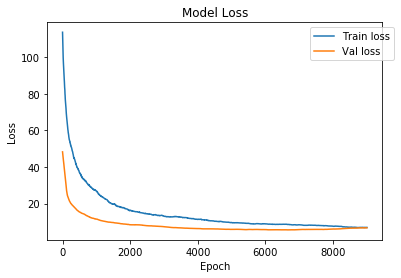

In [28]:
#Plot Model Loss

w = 1000
h1 = np.array(history.history['loss'])
h4 = np.array(history.history['val_loss'])
h1 = moving_average(h1,w)
h4 = moving_average(h4,w)
plt.plot(h1,label='Train loss')
plt.plot(h4,label='Val loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(bbox_to_anchor=(1.05, 1),loc='best')
plt.show()

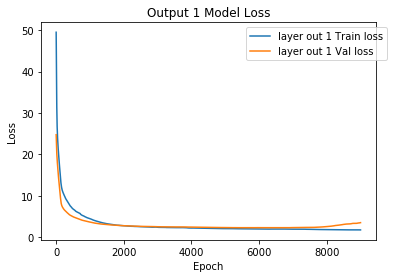

In [29]:
#Plot output 1 loss

h2 = np.array(history.history['out1_loss'])
h5 = np.array(history.history['val_out1_loss'])
h2 = moving_average(h2,w)
h5 = moving_average(h5,w)
plt.plot(h2,label='layer out 1 Train loss')
plt.plot(h5,label='layer out 1 Val loss')
plt.title('Output 1 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(bbox_to_anchor=(1.05, 1),loc='best')
plt.show()

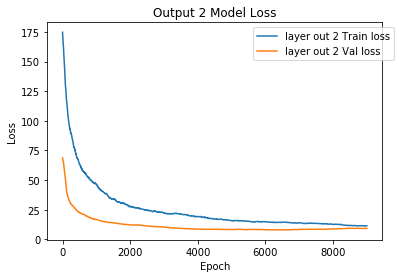

In [30]:
#Plot output 2 loss

h3 = np.array(history.history['out2_loss'])
h6 = np.array(history.history['val_out2_loss'])
h3 = moving_average(h3,w)
h6 = moving_average(h6,w)
plt.plot(h3,label='layer out 2 Train loss')
plt.plot(h6,label='layer out 2 Val loss')
plt.title('Output 2 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(bbox_to_anchor=(1.05, 1),loc='best')
plt.show()

In [32]:
#Load ground truth RUL

thr = mat['thr']
fleet_NUM = np.arange(0,pad,1)

rul = pd.read_csv(rul_file,index_col=False)
rul = (rul-1)/(thr-1)
rul_Fleet_All = np.zeros(100)
for x in range(100):
    rul_Fleet_All[x] = rul['RUL'][x]
rul_Fleet_All_Full = ((thr-1)*rul_Fleet_All) + 1
rul_Fleet_All_Full

array([50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50.,
       50., 50., 50., 50., 28., 50., 16., 50., 50., 50., 20., 50., 50.,
       50., 50., 50., 50.,  8., 48., 50.,  7., 11., 19., 21., 50., 50.,
       28., 18., 10., 50., 50., 50., 47., 50., 50., 21., 50., 50., 29.,
       26., 50., 50., 15., 50., 37., 50., 50., 21., 50., 50., 28., 50.,
       14., 50.,  8., 50., 50., 50., 50., 50., 50., 50., 10., 34., 50.,
       50., 50.,  8.,  9., 50., 50., 50., 50., 50., 50., 50., 28., 38.,
       20., 50., 50., 50., 50., 50., 50., 50., 20.])

In [33]:
#Make 100 predictions and calculate average performance

import sklearn
import math
from sklearn import metrics

rmse = np.zeros(100)
rmse1 = np.zeros(100)
sc = np.zeros(100)
sc1 = np.zeros(100)

for i in range(100):
    
    preds = model(x_test)
    tens_draw = preds[0].sample(1000)
    tens_draw1 = preds[1].sample(1000)
    tens_draw2 = preds[2]
    tens_draw = tf.keras.backend.get_value(tens_draw)
    tens_draw1 = tf.keras.backend.get_value(tens_draw1)
    tens_draw2 = tf.keras.backend.get_value(tens_draw2)

    #RMSE with AU

    mean_Fleet_All = np.zeros(tens_draw.shape[1])
    mean_Fleet = np.zeros(tens_draw.shape[0])
    for y in range(tens_draw.shape[1]):
        for x in range(tens_draw.shape[0]):
            mean_Fleet[x] = tens_draw[x,y,0]
        mean_Fleet_All[y] = mean_Fleet.mean()

    RUL_mse = sklearn.metrics.mean_squared_error(rul_Fleet_All_Full, mean_Fleet_All)
    RUL_rmse = math.sqrt(RUL_mse)
    rmse[i] = RUL_rmse

    #RMSE with EU

    mean_Fleet_All1 = np.zeros(tens_draw1.shape[1])
    mean_Fleet1 = np.zeros(tens_draw1.shape[0])
    for y in range(tens_draw1.shape[1]):
        for x in range(tens_draw1.shape[0]):
            mean_Fleet1[x] = tens_draw1[x,y,0]
        mean_Fleet_All1[y] = mean_Fleet1.mean()

    RUL_mse1 = sklearn.metrics.mean_squared_error(rul_Fleet_All_Full, mean_Fleet_All1)
    RUL_rmse1 = math.sqrt(RUL_mse1)
    rmse1[i] = RUL_rmse1
    
    score = mean_Fleet_All-rul_Fleet_All_Full

    for j in range(100):
        if score[j]<0:
            score[j]= math.exp((-score[j])/13)-1
        else:
            score[j] = math.exp(score[j]/10)-1
    
    sc[i] = np.sum(score)
    
    score1 = mean_Fleet_All1-rul_Fleet_All_Full

    for j in range(100):
        if score1[j]<0:
            score1[j]= math.exp((-score1[j])/13)-1
        else:
            score1[j] = math.exp(score1[j]/10)-1
    
    sc1[i] = np.sum(score1)

In [34]:
#Average RMSE with AU & EU
np.mean(rmse),np.mean(rmse1)

(14.752877824005623, 15.565511518283708)

In [35]:
#Average score with AU & EU
np.mean(sc),np.mean(sc1)

(412.3700397371672, 518.5241491749362)

In [36]:
#Calculate Mean & Std of prediction with AU

Fleet = pd.DataFrame(np.zeros((pad,tens_draw.shape[0])))
mean = pd.DataFrame(np.zeros((pad,tens_draw.shape[1])))
std = pd.DataFrame(np.zeros((pad,tens_draw.shape[1])))
for z in range(tens_draw.shape[1]):
    for y in range(tens_draw.shape[0]):
        for x in range(pad):
            Fleet[y][x] = tens_draw[y,z,x]
    row_Mean = Fleet.mean(axis=1)
    row_Std = Fleet.std(axis=1)
    for j in range(pad):
        mean[z][j] = row_Mean[j]
    for k in range(pad):
        std[z][k] = row_Std[k]

In [37]:
#Calculate Mean & Std of prediction with EU

Fleet1 = pd.DataFrame(np.zeros((pad,tens_draw1.shape[0])))
mean1 = pd.DataFrame(np.zeros((pad,tens_draw1.shape[1])))
std1 = pd.DataFrame(np.zeros((pad,tens_draw1.shape[1])))
for z in range(tens_draw1.shape[1]):
    for y in range(tens_draw1.shape[0]):
        for x in range(pad):
            Fleet1[y][x] = tens_draw1[y,z,x]
    row_Mean = Fleet1.mean(axis=1)
    row_Std = Fleet1.std(axis=1)
    for j in range(pad):
        mean1[z][j] = row_Mean[j]
    for k in range(pad):
        std1[z][k] = row_Std[k]

In [39]:
# Saves mean & std AU & EU

with open('Array_9_2.npy', 'wb') as f:
    np.save(f, tens_draw)
    np.save(f, tens_draw1)
    np.save(f, tens_draw2)
    np.save(f, mean)
    np.save(f, std)
    np.save(f, mean1)
    np.save(f, std1)
    
#with open('Array_9.npy', 'rb') as f:
    #tens_draw = np.load(f)
    #tens_draw1 = np.load(f)
    #tens_draw2 = np.load(f)
    #mean = np.load(f)
    #std = np.load(f)
    #mean1 = np.load(f)
    #std1 = np.load(f)

In [40]:
#Load ground truth RUL

fleet_RUL = pd.read_csv(fleet_Rul_File, skiprows = 0,header = None)

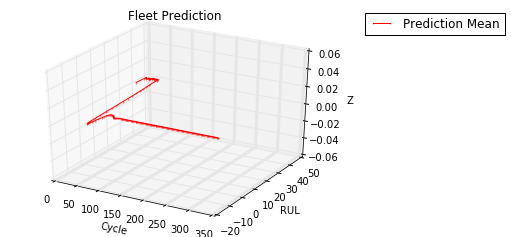

In [41]:
#3d visualization of prediction

from mpl_toolkits import mplot3d
import seaborn as sns
from scipy import stats
from scipy.stats import norm
plt.style.use('classic')
%matplotlib inline
ax = plt.axes(projection='3d')
ax.xaxis._axinfo["grid"].update({"linewidth":3})

i = 17

ax.set_title("Fleet Prediction")
ax.set_xlabel('Cycle')
ax.set_ylabel('RUL')
ax.set_zlabel('Z')


mu = mean[0][i]
sigma = std[0][i]
x = np.full((1000,),i)
s = np.arange(0,303,1)
Fleet1 = Fleet.iloc[i:i+1,:].to_numpy()
Fleet1 = Fleet1.reshape(1000,)
mindist = Fleet1.min()
maxdist = Fleet1.max()
y = np.linspace(mindist,maxdist,1000)
ax.plot3D(s,mean[0],linewidth=1,marker="+",markersize=1,color='red',label='Prediction Mean')
#ax.scatter3D(x,Fleet1,marker= "o",color='grey',linewidth=0.2,label='Predictions')
#ax.plot3D(x,y,stats.norm.pdf(y, mu, sigma),color='blue',label='Prediction Distribution')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('3D_1.jpg',bbox_inches='tight')
plt.show()

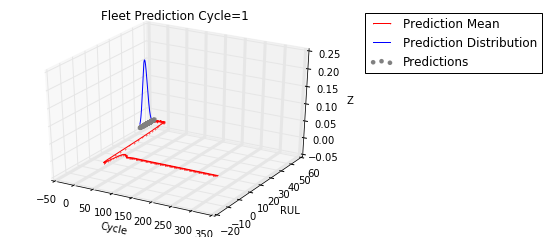

In [42]:
#3d visualization of prediction

plt.style.use('classic')
%matplotlib inline
ax = plt.axes(projection='3d')
ax.xaxis._axinfo["grid"].update({"linewidth":3})

i = 0

ax.set_title("Fleet Prediction Cycle=1")
ax.set_xlabel('Cycle')
ax.set_ylabel('RUL')
ax.set_zlabel('Z')


mu = mean[0][i]
sigma = std[0][i]
x = np.full((1000,),i)
s = np.arange(0,303,1)
Fleet1 = Fleet.iloc[i:i+1,:].to_numpy()
Fleet1 = Fleet1.reshape(1000,)
mindist = Fleet1.min()
maxdist = Fleet1.max()
y = np.linspace(mindist,maxdist,1000)
ax.plot3D(s,mean[0],linewidth=1,marker="+",markersize=1,color='red',label='Prediction Mean')
ax.scatter3D(x,Fleet1,marker= "o",color='grey',linewidth=0.1,label='Predictions')
ax.plot3D(x,y,stats.norm.pdf(y, mu, sigma),color='blue',label='Prediction Distribution')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('3D_1.jpg',bbox_inches='tight')
plt.show()

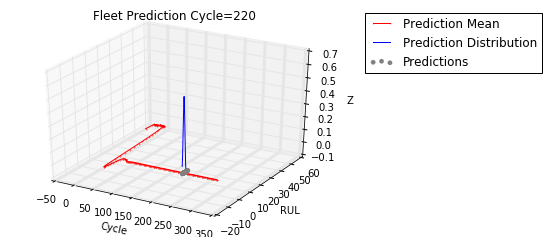

In [43]:
#3d visualization of prediction

plt.style.use('classic')
%matplotlib inline
ax = plt.axes(projection='3d')
ax.xaxis._axinfo["grid"].update({"linewidth":3})

i = 219

ax.set_title("Fleet Prediction Cycle=220")
ax.set_xlabel('Cycle')
ax.set_ylabel('RUL')
ax.set_zlabel('Z')


mu = mean[0][i]
sigma = std[0][i]
x = np.full((1000,),i)
s = np.arange(0,303,1)
Fleet1 = Fleet.iloc[i:i+1,:].to_numpy()
Fleet1 = Fleet1.reshape(1000,)
mindist = Fleet1.min()
maxdist = Fleet1.max()
y = np.linspace(mindist,maxdist,1000)
ax.plot3D(s,mean[0],linewidth=1,marker="+",markersize=1,color='red',label='Prediction Mean')
ax.scatter3D(x,Fleet1,marker= "o",color='grey',linewidth=0.2,label='Predictions')
ax.plot3D(x,y,stats.norm.pdf(y,mean[0][i],std[0][i]),color='blue',label='Prediction Distribution')
plt.legend(bbox_to_anchor=(1.05,1),loc='upper left')
plt.savefig('3D_2.jpg',bbox_inches='tight')
plt.show()

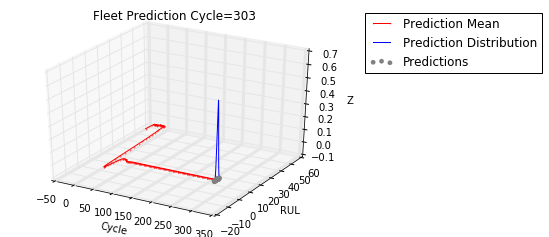

In [44]:
#3d visualization of prediction

plt.style.use('classic')
%matplotlib inline
ax = plt.axes(projection='3d')
ax.xaxis._axinfo["grid"].update({"linewidth":3})

i = 302

ax.set_title("Fleet Prediction Cycle=303")
ax.set_xlabel('Cycle')
ax.set_ylabel('RUL')
ax.set_zlabel('Z')


mu = mean[0][i]
sigma = std[0][i]
x = np.full((1000,),i)
s = np.arange(0,303,1)
Fleet1 = Fleet.iloc[i:i+1,:].to_numpy()
Fleet1 = Fleet1.reshape(1000,)
mindist = Fleet1.min()
maxdist = Fleet1.max()
y = np.linspace(mindist,maxdist,1000)
ax.plot3D(s,mean[0],linewidth=1,marker="+",markersize=1,color='red',label='Prediction Mean')
ax.scatter3D(x,Fleet1,marker= "o",color='grey',linewidth=0.2,label='Predictions')
ax.plot3D(x,y,stats.norm.pdf(y,mean[0][i],std[0][i]),color='blue',label='Prediction Distribution')
plt.legend(bbox_to_anchor=(1.05,1),loc='upper left')
plt.savefig('3D_3.jpg',bbox_inches='tight')
plt.show()

In [46]:
#Define cycle when RUL ground truth become 0

cycle_lim = np.zeros(100)
S = 0
for K in range(100):
    for L in range(pad):
        if fleet_RUL[K][L] == 0:
            S = 0
            break
        else:
            S = S + 1
            cycle_lim[K] = S

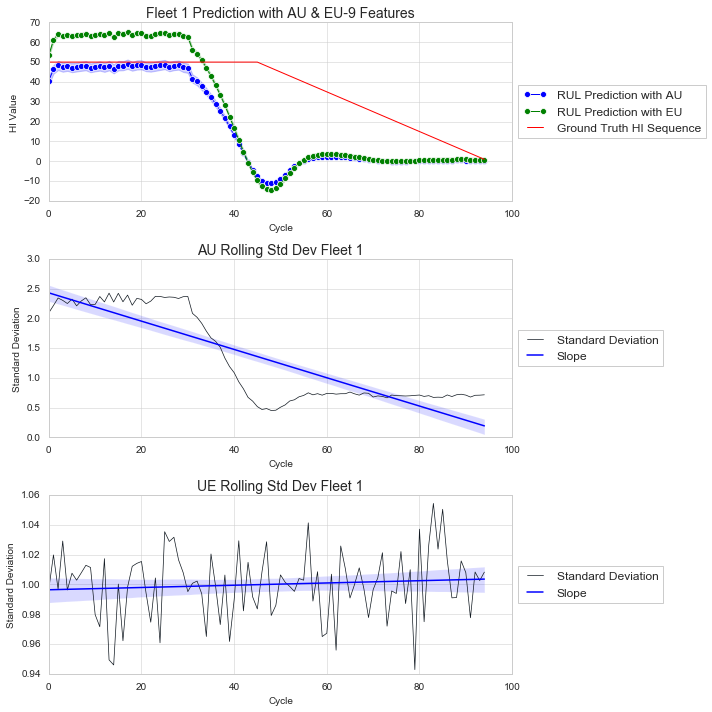

In [47]:
#Visualization Fleet 1

import seaborn as sns
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from scipy import stats
sns.set_style("whitegrid")
for B in range(0,1):
    lim = int(cycle_lim[B]+1)
    lim2 = int(cycle_lim[B]+1)
    max_Seq = pd.DataFrame(np.zeros((lim,tens_draw.shape[0])))
    for y in range(tens_draw.shape[0]):
        for x in range(lim):
            max_Seq[y][x] = tens_draw[y,B,x]

    max_Seq_Arrange = pd.DataFrame(np.zeros((lim*tens_draw.shape[0],2)))
    z = 0
    m = 0
    s = 0
    while s < lim*tens_draw.shape[0]:
        if(m < (tens_draw.shape[0])):
            max_Seq_Arrange[0][s] = fleet_NUM[z]
            max_Seq_Arrange[1][s] = max_Seq[m][z]
            m = m + 1
            s = s + 1
        else:
            #print("change")
            z = z + 1
            m = 0
        continue
    
    max_Seq1 = pd.DataFrame(np.zeros((lim,tens_draw1.shape[0])))
    for y in range(tens_draw1.shape[0]):
        for x in range(lim):
            max_Seq1[y][x] = tens_draw1[y,B,x]

    max_Seq_Arrange1 = pd.DataFrame(np.zeros((lim*tens_draw1.shape[0],2)))
    z = 0
    m = 0
    s = 0
    while s < lim*tens_draw1.shape[0]:
        if(m < (tens_draw1.shape[0])):
            max_Seq_Arrange1[0][s] = fleet_NUM[z]
            max_Seq_Arrange1[1][s] = max_Seq1[m][z]
            m = m + 1
            s = s + 1
        else:
            #print("change")
            z = z + 1
            m = 0
        continue

    max_Seq_Arrange.columns = ['Cycle','HI Value']
    max_RUL_Arrange = pd.DataFrame(np.zeros((lim2,2)))
    for x in range(lim2):
        max_RUL_Arrange[0][x] = fleet_NUM[x]
        max_RUL_Arrange[1][x] = ((thr-1)*fleet_RUL[B][x]) + 1
    max_RUL_Arrange.columns = ['Cycle','HI Value']
    
    max_Seq_Arrange1.columns = ['Cycle','HI Value']

    min_Std_Arrange = pd.DataFrame(np.zeros((lim,2)))
    for x in range(lim):
        min_Std_Arrange[0][x] = fleet_NUM[x]
        min_Std_Arrange[1][x] = std[B][x]
    min_Std_Arrange.columns = ['Cycle','HI Value']
    
    med_Std_Arrange = pd.DataFrame(np.zeros((lim,2)))
    for x in range(lim):
        med_Std_Arrange[0][x] = fleet_NUM[x]
        med_Std_Arrange[1][x] = std1[B][x]
    med_Std_Arrange.columns = ['Cycle','HI Value']
    
    # get coeffs of linear fit
    slope, intercept, r_value, p_value, std_err = stats.linregress(min_Std_Arrange['Cycle'],min_Std_Arrange['HI Value'])
    gs = gridspec.GridSpec(3,1)
    fig = plt.figure(figsize=(10,10))

    ax = fig.add_subplot(gs[0])
    sns.lineplot(x="Cycle", y="HI Value",ci = "sd", marker='o', data=max_Seq_Arrange, ax=ax, label="RUL Prediction with AU")
    sns.lineplot(x="Cycle", y="HI Value",ci = "sd", marker='o', data=max_Seq_Arrange1, ax=ax, label="RUL Prediction with EU")
    sns.lineplot(x="Cycle", y="HI Value", data = max_RUL_Arrange, color='red', ax=ax,label="Ground Truth HI Sequence")
    plt.title('Fleet %i Prediction with AU & EU-9 Features' %(B+1),fontsize=14)
    ax.set_xlabel('Cycle')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax = fig.add_subplot(gs[1],sharex=ax)
    ax.plot('Cycle', 'HI Value', data=min_Std_Arrange,linestyle= '-', color = '#101820FF',linewidth=0.7, label='Standard Deviation')
    sns.regplot(min_Std_Arrange['Cycle'],min_Std_Arrange['HI Value'],scatter = False,label='Slope')
    plt.title('AU Rolling Std Dev Fleet %i' %(B+1),fontsize=14)
    ax.set_xlabel('Cycle')
    ax.set_ylabel('Standard Deviation')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    ax = fig.add_subplot(gs[2],sharex=ax)
    ax.plot('Cycle', 'HI Value', data=med_Std_Arrange,linestyle= '-', color = '#101820FF',linewidth=0.7, label='Standard Deviation')
    sns.regplot(med_Std_Arrange['Cycle'],med_Std_Arrange['HI Value'],scatter = False,label='Slope')
    plt.title('UE Rolling Std Dev Fleet %i' %(B+1),fontsize=14)
    ax.set_xlabel('Cycle')
    ax.set_ylabel('Standard Deviation')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig("Fleet %i Pred" %B+'.jpg')
    plt.tight_layout()
    plt.show()

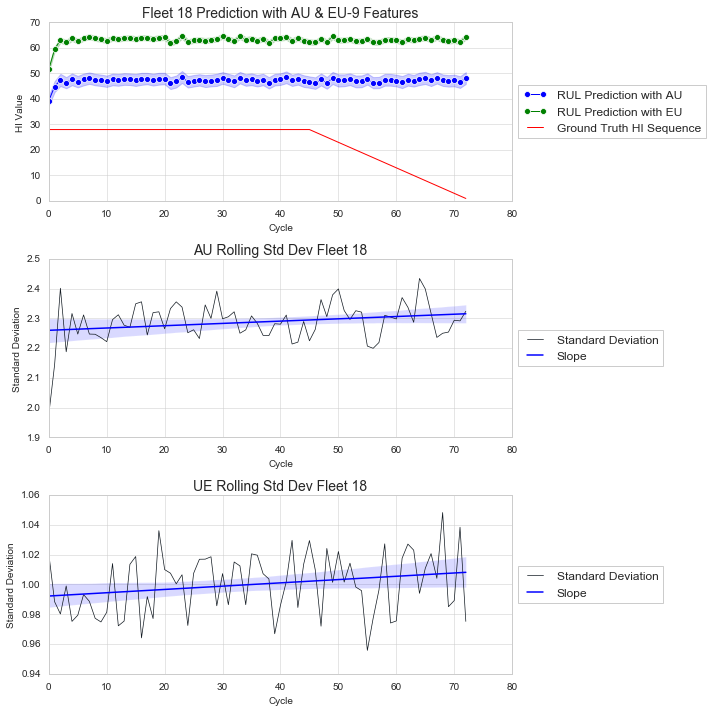

In [48]:
#Visualization Fleet 18

import seaborn as sns
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from scipy import stats
sns.set_style("whitegrid")
for B in range(17,18):
    lim = int(cycle_lim[B]+1)
    lim2 = int(cycle_lim[B]+1)
    max_Seq = pd.DataFrame(np.zeros((lim,tens_draw.shape[0])))
    for y in range(tens_draw.shape[0]):
        for x in range(lim):
            max_Seq[y][x] = tens_draw[y,B,x]

    max_Seq_Arrange = pd.DataFrame(np.zeros((lim*tens_draw.shape[0],2)))
    z = 0
    m = 0
    s = 0
    while s < lim*tens_draw.shape[0]:
        if(m < (tens_draw.shape[0])):
            max_Seq_Arrange[0][s] = fleet_NUM[z]
            max_Seq_Arrange[1][s] = max_Seq[m][z]
            m = m + 1
            s = s + 1
        else:
            #print("change")
            z = z + 1
            m = 0
        continue
    
    max_Seq1 = pd.DataFrame(np.zeros((lim,tens_draw1.shape[0])))
    for y in range(tens_draw1.shape[0]):
        for x in range(lim):
            max_Seq1[y][x] = tens_draw1[y,B,x]

    max_Seq_Arrange1 = pd.DataFrame(np.zeros((lim*tens_draw1.shape[0],2)))
    z = 0
    m = 0
    s = 0
    while s < lim*tens_draw1.shape[0]:
        if(m < (tens_draw1.shape[0])):
            max_Seq_Arrange1[0][s] = fleet_NUM[z]
            max_Seq_Arrange1[1][s] = max_Seq1[m][z]
            m = m + 1
            s = s + 1
        else:
            #print("change")
            z = z + 1
            m = 0
        continue

    max_Seq_Arrange.columns = ['Cycle','HI Value']
    max_RUL_Arrange = pd.DataFrame(np.zeros((lim2,2)))
    for x in range(lim2):
        max_RUL_Arrange[0][x] = fleet_NUM[x]
        max_RUL_Arrange[1][x] = ((thr-1)*fleet_RUL[B][x]) + 1
    max_RUL_Arrange.columns = ['Cycle','HI Value']
    
    max_Seq_Arrange1.columns = ['Cycle','HI Value']

    min_Std_Arrange = pd.DataFrame(np.zeros((lim,2)))
    for x in range(lim):
        min_Std_Arrange[0][x] = fleet_NUM[x]
        min_Std_Arrange[1][x] = std[B][x]
    min_Std_Arrange.columns = ['Cycle','HI Value']
    
    med_Std_Arrange = pd.DataFrame(np.zeros((lim,2)))
    for x in range(lim):
        med_Std_Arrange[0][x] = fleet_NUM[x]
        med_Std_Arrange[1][x] = std1[B][x]
    med_Std_Arrange.columns = ['Cycle','HI Value']
    
    # get coeffs of linear fit
    slope, intercept, r_value, p_value, std_err = stats.linregress(min_Std_Arrange['Cycle'],min_Std_Arrange['HI Value'])
    gs = gridspec.GridSpec(3,1)
    fig = plt.figure(figsize=(10,10))

    ax = fig.add_subplot(gs[0])
    sns.lineplot(x="Cycle", y="HI Value",ci = "sd", marker='o', data=max_Seq_Arrange, ax=ax, label="RUL Prediction with AU")
    sns.lineplot(x="Cycle", y="HI Value",ci = "sd", marker='o', data=max_Seq_Arrange1, ax=ax, label="RUL Prediction with EU")
    sns.lineplot(x="Cycle", y="HI Value", data = max_RUL_Arrange, color='red', ax=ax,label="Ground Truth HI Sequence")
    plt.title('Fleet %i Prediction with AU & EU-9 Features' %(B+1),fontsize=14)
    ax.set_xlabel('Cycle')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax = fig.add_subplot(gs[1],sharex=ax)
    ax.plot('Cycle', 'HI Value', data=min_Std_Arrange,linestyle= '-', color = '#101820FF',linewidth=0.7, label='Standard Deviation')
    sns.regplot(min_Std_Arrange['Cycle'],min_Std_Arrange['HI Value'],scatter = False,label='Slope')
    plt.title('AU Rolling Std Dev Fleet %i' %(B+1),fontsize=14)
    ax.set_xlabel('Cycle')
    ax.set_ylabel('Standard Deviation')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    ax = fig.add_subplot(gs[2],sharex=ax)
    ax.plot('Cycle', 'HI Value', data=med_Std_Arrange,linestyle= '-', color = '#101820FF',linewidth=0.7, label='Standard Deviation')
    sns.regplot(med_Std_Arrange['Cycle'],med_Std_Arrange['HI Value'],scatter = False,label='Slope')
    plt.title('UE Rolling Std Dev Fleet %i' %(B+1),fontsize=14)
    ax.set_xlabel('Cycle')
    ax.set_ylabel('Standard Deviation')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig("Fleet %i Pred" %B+'.jpg')
    plt.tight_layout()
    plt.show()

In [49]:
#SHAP cannot be used with model with probabilistic layers. So, transfer learned weights of probabilistic LSTM to a new LSTM without probabilistic layers
#Define New LSTM without probabilistic layers for explanation

inputs = tf.keras.Input(shape=(303,9),dtype='float32')
layer1 = LSTM(unit1,return_sequences = True)(inputs)
layer2 = Dense(size1)(layer1)
layer3 = Dense(1)(layer2)
layer4 = Lambda(lambda t: t[:,-1],name='out2')(layer3)
model2 = tf.keras.Model(inputs=inputs, outputs=layer4)
model2.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 303, 9)]          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 303, 51)           12444     
_________________________________________________________________
dense_6 (Dense)              (None, 303, 171)          8892      
_________________________________________________________________
dense_7 (Dense)              (None, 303, 1)            172       
_________________________________________________________________
out2 (Lambda)                (None, 1)                 0         
Total params: 21,508
Trainable params: 21,508
Non-trainable params: 0
_________________________________________________________________


In [50]:
#Transfer weights from old LSTM to new LSTM

model2.layers[0].set_weights(model.layers[0].get_weights())
model2.layers[1].set_weights(model.layers[1].get_weights())
model2.layers[2].set_weights(model.layers[2].get_weights())
model2.layers[3].set_weights(model.layers[5].get_weights())
model2.layers[4].set_weights(model.layers[8].get_weights())

In [51]:
#Prediction with new LSTM

preds2 = model2(x_test)
y3 = preds2
y3 = tf.keras.backend.get_value(y3)
tens_draw3 = y3

In [52]:
#Import SHAP & initialized JS

import shap
shap.initjs()

In [53]:
#Extract Feature Names

features = pd.read_csv(train_file, index_col=False)
features = features.drop(['Fleet','Cycle','RUL'],axis=1)
features = np.array(list(features.columns))
features

array(['OC1', 'OC3', 'S3', 'S4', 'S8', 'S11', 'S12', 'S13', 'S15'],
      dtype='<U3')

In [54]:
#load Training Files into Pandas Dataframes for SHAP Plots

xtrain = pd.read_csv(train_file, index_col=False)
xtrain = xtrain.drop(['Fleet','Cycle','RUL'],axis=1)

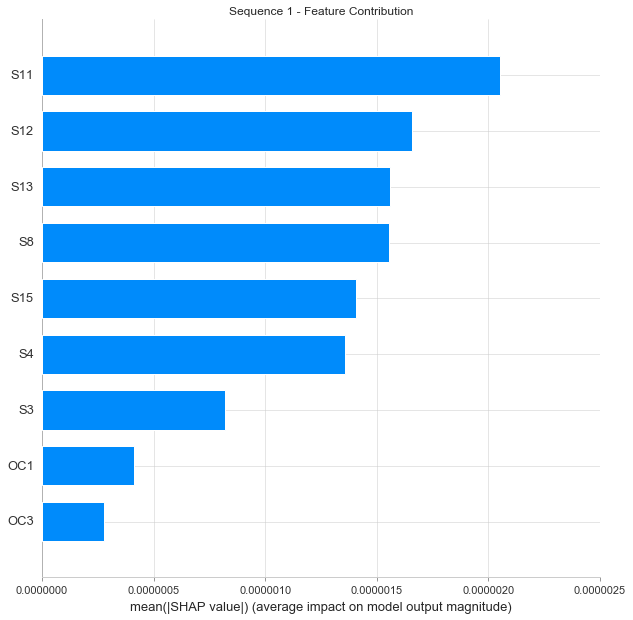

In [55]:
#SHAP Summmary Plot Fleet 1

instance = x_train
instance2 = x_test
explainer = shap.DeepExplainer(model2,instance)
shap_values = explainer.shap_values(instance2)
for i in range(0,1):
    shap.summary_plot(shap_values[0][i],feature_names=xtrain.columns,show=False,plot_size=(10, 10),plot_type="bar")
    plt.title("Sequence %i - Feature Contribution" %(i+1),fontsize=12)
    #plt.savefig("Sum_Plot %i" %i+'.png')
    #plt.figure

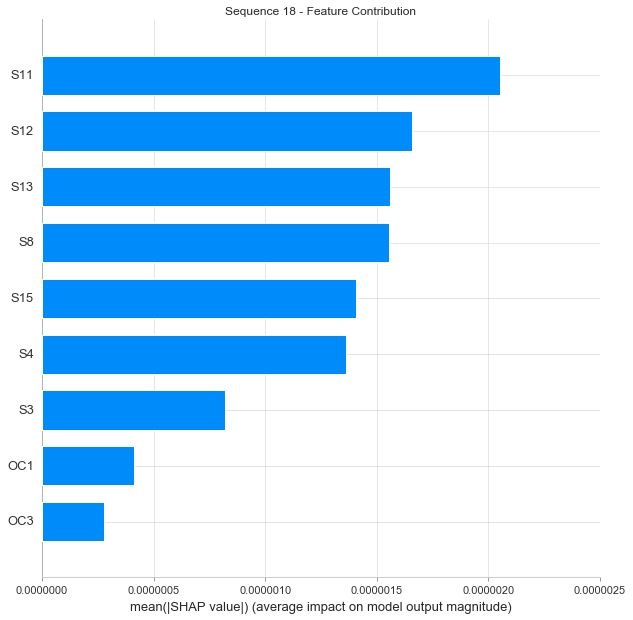

In [56]:
#SHAP Summmary Plot Fleet 18

for i in range(17,18):
    shap.summary_plot(shap_values[0][i],feature_names=xtrain.columns,show=False,plot_size=(10, 10),plot_type="bar")
    plt.title("Sequence %i - Feature Contribution" %(i+1),fontsize=12)

In [57]:
#SHAP Force Plot Fleet 1

import seaborn as sns
sns.set_style("ticks")
for s in range(0,1):
    instance=x_test[s:s+1]
    shap_values = explainer.shap_values(instance)
    e = explainer.expected_value
    # Per individual array 
    for j in range(303):
        print(s+1,j+1)
        xtest_df = pd.DataFrame(data = x_test[s][j].reshape(1,9),columns=features).round(3)
        shap_display = shap.force_plot(e[0],shap_values[0][0][j],xtest_df,matplotlib = False,show = False,figsize=(10, 2),text_rotation=15)
        display(shap_display)

1 1


1 2


1 3


1 4


1 5


1 6


1 7


1 8


1 9


1 10


1 11


1 12


1 13


1 14


1 15


1 16


1 17


1 18


1 19


1 20


1 21


1 22


1 23


1 24


1 25


1 26


1 27


1 28


1 29


1 30


1 31


1 32


1 33


1 34


1 35


1 36


1 37


1 38


1 39


1 40


1 41


1 42


1 43


1 44


1 45


1 46


1 47


1 48


1 49


1 50


1 51


1 52


1 53


1 54


1 55


1 56


1 57


1 58


1 59


1 60


1 61


1 62


1 63


1 64


1 65


1 66


1 67


1 68


1 69


1 70


1 71


1 72


1 73


1 74


1 75


1 76


1 77


1 78


1 79


1 80


1 81


1 82


1 83


1 84


1 85


1 86


1 87


1 88


1 89


1 90


1 91


1 92


1 93


1 94


1 95


1 96


1 97


1 98


1 99


1 100


1 101


1 102


1 103


1 104


1 105


1 106


1 107


1 108


1 109


1 110


1 111


1 112


1 113


1 114


1 115


1 116


1 117


1 118


1 119


1 120


1 121


1 122


1 123


1 124


1 125


1 126


1 127


1 128


1 129


1 130


1 131


1 132


1 133


1 134


1 135


1 136


1 137


1 138


1 139


1 140


1 141


1 142


1 143


1 144


1 145


1 146


1 147


1 148


1 149


1 150


1 151


1 152


1 153


1 154


1 155


1 156


1 157


1 158


1 159


1 160


1 161


1 162


1 163


1 164


1 165


1 166


1 167


1 168


1 169


1 170


1 171


1 172


1 173


1 174


1 175


1 176


1 177


1 178


1 179


1 180


1 181


1 182


1 183


1 184


1 185


1 186


1 187


1 188


1 189


1 190


1 191


1 192


1 193


1 194


1 195


1 196


1 197


1 198


1 199


1 200


1 201


1 202


1 203


1 204


1 205


1 206


1 207


1 208


1 209


1 210


1 211


1 212


1 213


1 214


1 215


1 216


1 217


1 218


1 219


1 220


1 221


1 222


1 223


1 224


1 225


1 226


1 227


1 228


1 229


1 230


1 231


1 232


1 233


1 234


1 235


1 236


1 237


1 238


1 239


1 240


1 241


1 242


1 243


1 244


1 245


1 246


1 247


1 248


1 249


1 250


1 251


1 252


1 253


1 254


1 255


1 256


1 257


1 258


1 259


1 260


1 261


1 262


1 263


1 264


1 265


1 266


1 267


1 268


1 269


1 270


1 271


1 272


1 273


1 274


1 275


1 276


1 277


1 278


1 279


1 280


1 281


1 282


1 283


1 284


1 285


1 286


1 287


1 288


1 289


1 290


1 291


1 292


1 293


1 294


1 295


1 296


1 297


1 298


1 299


1 300


1 301


1 302


1 303


In [58]:
#SHAP Force Plot Fleet 18

for s in range(17,18):
    instance=x_test[s:s+1]
    shap_values = explainer.shap_values(instance)
    e = explainer.expected_value
    # Per individual array 
    for j in range(303):
        print(s+1,j+1)
        xtest_df = pd.DataFrame(data = x_test[s][j].reshape(1,9),columns=features).round(3)
        shap_display = shap.force_plot(e[0],shap_values[0][0][j],xtest_df,matplotlib = False,show = False,figsize=(10, 2),text_rotation=15)
        display(shap_display)

18 1


18 2


18 3


18 4


18 5


18 6


18 7


18 8


18 9


18 10


18 11


18 12


18 13


18 14


18 15


18 16


18 17


18 18


18 19


18 20


18 21


18 22


18 23


18 24


18 25


18 26


18 27


18 28


18 29


18 30


18 31


18 32


18 33


18 34


18 35


18 36


18 37


18 38


18 39


18 40


18 41


18 42


18 43


18 44


18 45


18 46


18 47


18 48


18 49


18 50


18 51


18 52


18 53


18 54


18 55


18 56


18 57


18 58


18 59


18 60


18 61


18 62


18 63


18 64


18 65


18 66


18 67


18 68


18 69


18 70


18 71


18 72


18 73


18 74


18 75


18 76


18 77


18 78


18 79


18 80


18 81


18 82


18 83


18 84


18 85


18 86


18 87


18 88


18 89


18 90


18 91


18 92


18 93


18 94


18 95


18 96


18 97


18 98


18 99


18 100


18 101


18 102


18 103


18 104


18 105


18 106


18 107


18 108


18 109


18 110


18 111


18 112


18 113


18 114


18 115


18 116


18 117


18 118


18 119


18 120


18 121


18 122


18 123


18 124


18 125


18 126


18 127


18 128


18 129


18 130


18 131


18 132


18 133


18 134


18 135


18 136


18 137


18 138


18 139


18 140


18 141


18 142


18 143


18 144


18 145


18 146


18 147


18 148


18 149


18 150


18 151


18 152


18 153


18 154


18 155


18 156


18 157


18 158


18 159


18 160


18 161


18 162


18 163


18 164


18 165


18 166


18 167


18 168


18 169


18 170


18 171


18 172


18 173


18 174


18 175


18 176


18 177


18 178


18 179


18 180


18 181


18 182


18 183


18 184


18 185


18 186


18 187


18 188


18 189


18 190


18 191


18 192


18 193


18 194


18 195


18 196


18 197


18 198


18 199


18 200


18 201


18 202


18 203


18 204


18 205


18 206


18 207


18 208


18 209


18 210


18 211


18 212


18 213


18 214


18 215


18 216


18 217


18 218


18 219


18 220


18 221


18 222


18 223


18 224


18 225


18 226


18 227


18 228


18 229


18 230


18 231


18 232


18 233


18 234


18 235


18 236


18 237


18 238


18 239


18 240


18 241


18 242


18 243


18 244


18 245


18 246


18 247


18 248


18 249


18 250


18 251


18 252


18 253


18 254


18 255


18 256


18 257


18 258


18 259


18 260


18 261


18 262


18 263


18 264


18 265


18 266


18 267


18 268


18 269


18 270


18 271


18 272


18 273


18 274


18 275


18 276


18 277


18 278


18 279


18 280


18 281


18 282


18 283


18 284


18 285


18 286


18 287


18 288


18 289


18 290


18 291


18 292


18 293


18 294


18 295


18 296


18 297


18 298


18 299


18 300


18 301


18 302


18 303
